In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      ICP.L
1     ABDN.L
2     SMDS.L
4       HL.L
5      DPH.L
6      HIK.L
7     HWDN.L
8      IDS.L
9      ITV.L
10     CCL.L
11    INVP.L
12     CNA.L
13    CTEC.L
14     UTG.L
15    JMAT.L
16    WEIR.L
18    BBOX.L
19     EZJ.L
20     IMI.L
21     DLN.L
22     TUI.L
23     SXS.L
24     HSX.L
25     DLG.L
26     EMG.L
27    DPLM.L
28     IGG.L
29    WIZZ.L
30    FRAS.L
31    TATE.L
32     BEZ.L
33     PNN.L
34     RSW.L
Name: Ticker_Symbol, dtype: object

In [5]:
data = price_volume_data(symbols_short.to_list(),'2017-05-25', '2022-05-31')
data.pv

{'ICP.L':                                   Open         High          Low        Close  \
 Date                                                                            
 2017-05-25 00:00:00+01:00   632.439140   728.545088   629.927992   713.044128   
 2017-05-26 00:00:00+01:00   712.269005   725.057295   688.630045   691.342712   
 2017-05-30 00:00:00+01:00   687.080036   694.442992   681.267177   682.429749   
 2017-05-31 00:00:00+01:00   681.654654   687.855037   680.492082   683.979797   
 2017-06-01 00:00:00+01:00   685.917518   694.055522   679.717134   686.692566   
 ...                                ...          ...          ...          ...   
 2022-05-24 00:00:00+01:00  1312.555141  1337.080392  1308.921770  1323.909424   
 2022-05-25 00:00:00+01:00  1344.346992  1344.346992  1307.104947  1324.817627   
 2022-05-26 00:00:00+01:00  1379.318323  1451.531565  1372.051582  1425.643799   
 2022-05-27 00:00:00+01:00  1419.285366  1457.889927  1417.014509  1449.714844   
 2022-0

In [6]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

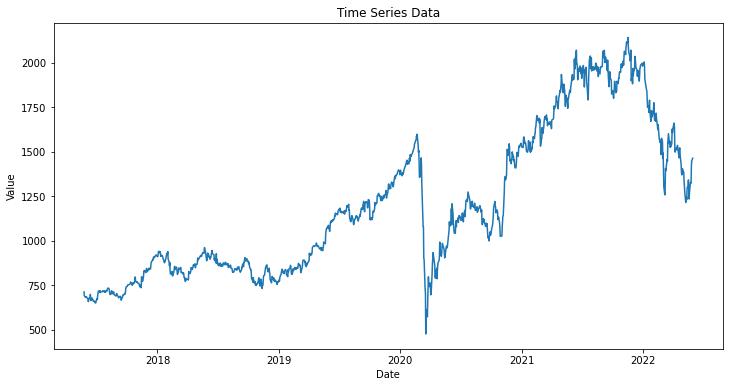

ADF Statistic: -1.6725934859085956
p-value: 0.44528556297382643
Critical Values:
1%: -3.43554227494792
5%: -2.8638329319593185
10%: -2.5679907811664124
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12179.400, Time=2.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12181.396, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12181.396, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12177.910, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12181.663, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.790 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6087.955
Date:                Thu, 12 Oct 2023   AIC                          12177.910
Time:                        11:30:25   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


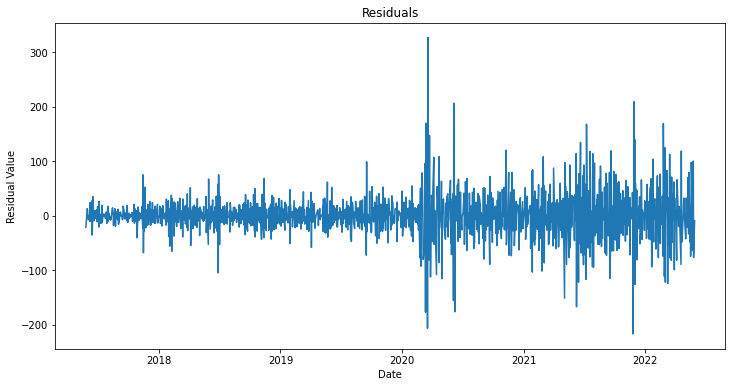

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


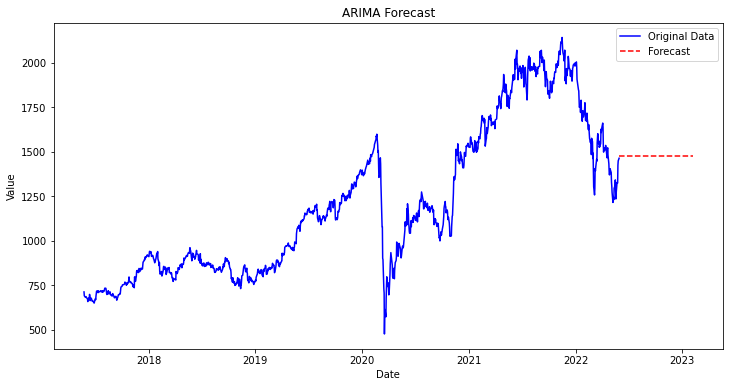

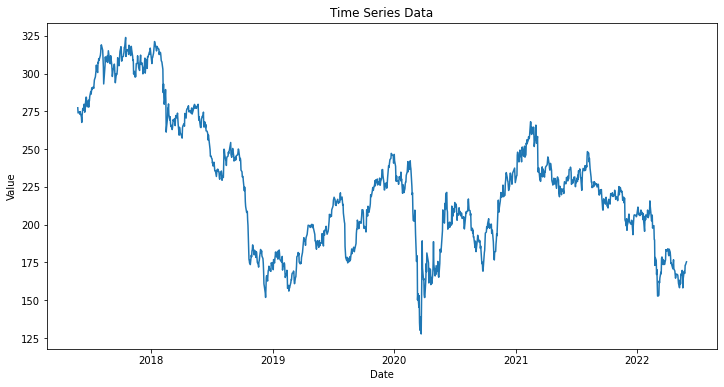

ADF Statistic: -1.8615200776965413
p-value: 0.3503740462501288
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7337.713, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7338.818, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7338.832, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7336.142, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7340.363, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.480 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3667.071
Date:                Thu, 12 Oct 2023   AIC                           7336.142
Time:                        11:30:27   BIC            

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


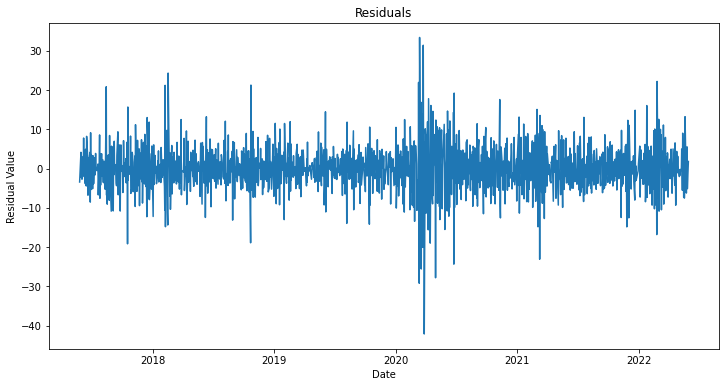

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


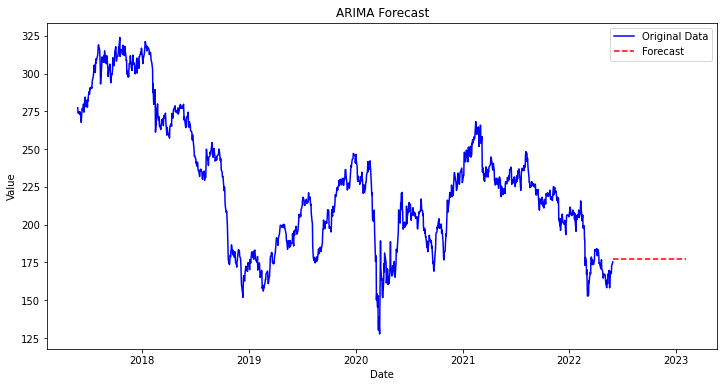

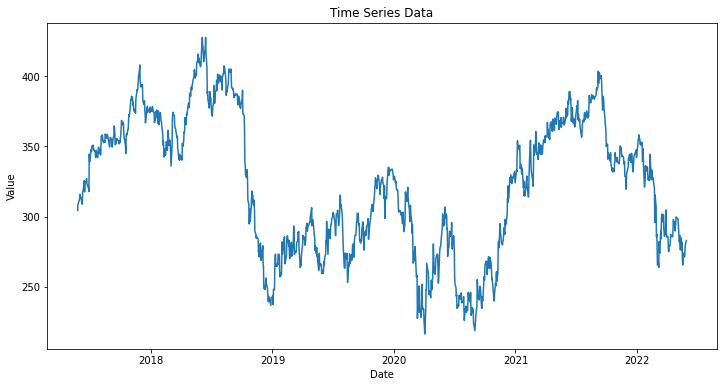

ADF Statistic: -2.1726932395755862
p-value: 0.21630506162093172
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8166.375, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8167.009, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8166.957, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8164.385, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8167.329, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4081.192
Date:                Thu, 12 Oct 2023   AIC                           8164.385
Time:                        11:30:28   BIC        

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


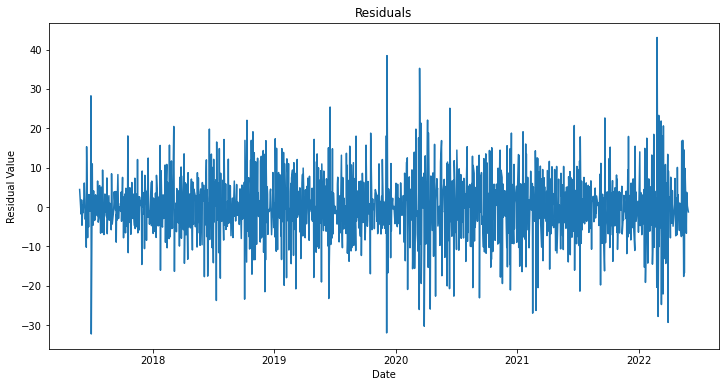

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


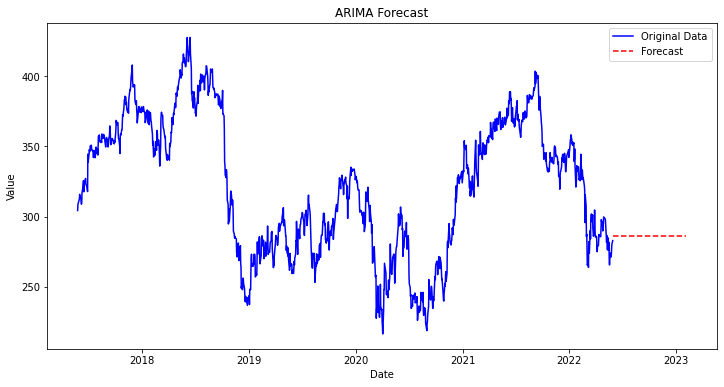

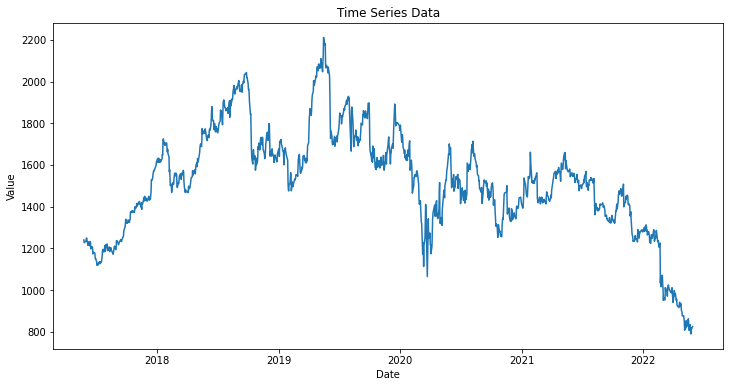

ADF Statistic: -1.7305843934732363
p-value: 0.4154273375623506
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12396.082, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12397.783, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12397.770, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12394.213, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12399.726, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6196.107
Date:                Thu, 12 Oct 2023   AIC                          12394.213
Time:                        11:30:29   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


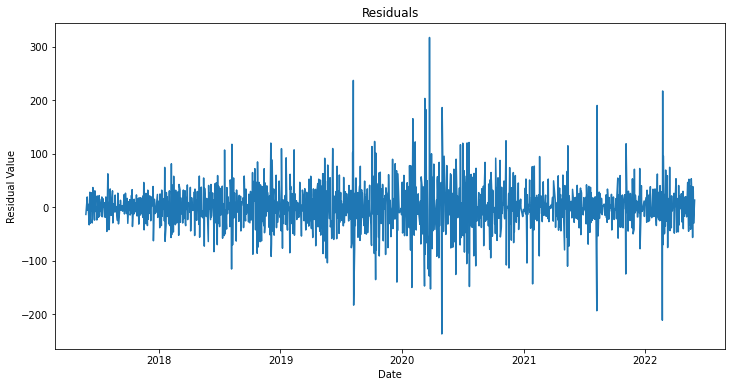

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


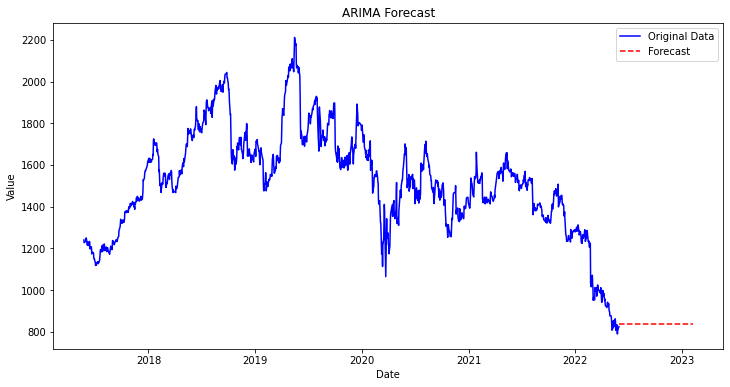

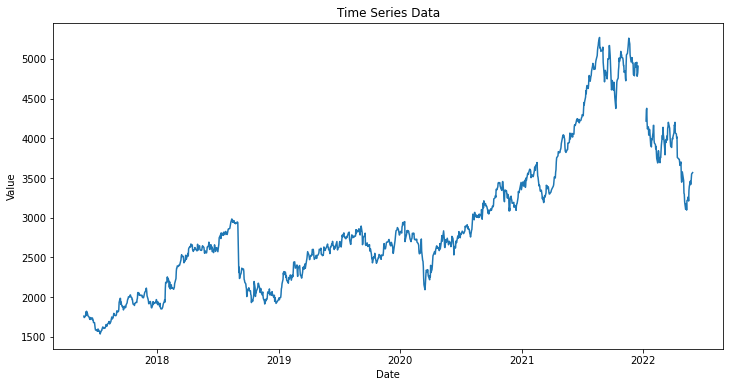

ADF Statistic: -1.4523122524095309
p-value: 0.5569562370613794
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13716.383, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13715.192, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13715.239, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13715.201, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13717.158, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13717.168, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13718.753, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13713.931, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13715.890, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13715.895, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13713.980, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AI

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


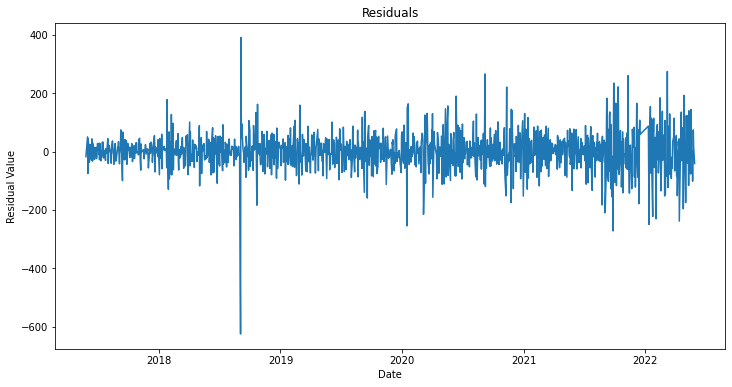

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


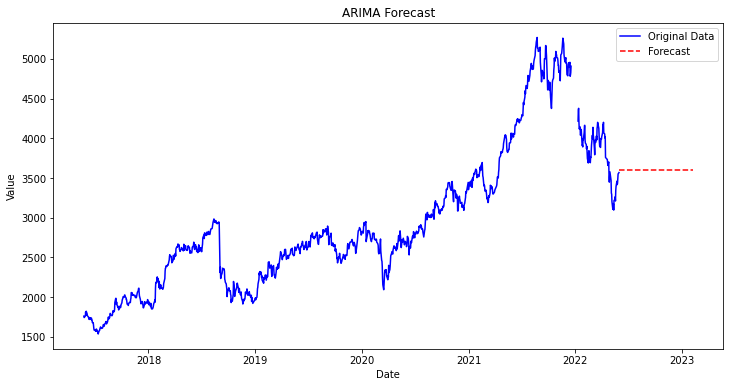

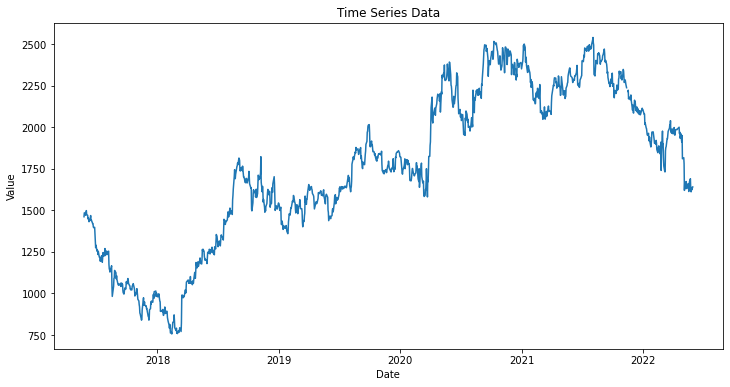

ADF Statistic: -1.4065872965632324
p-value: 0.5791140430544127
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12642.233, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12642.192, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12642.076, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12640.253, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12642.682, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.604 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6319.126
Date:                Thu, 12 Oct 2023   AIC                          12640.253
Time:                        11:30:33   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


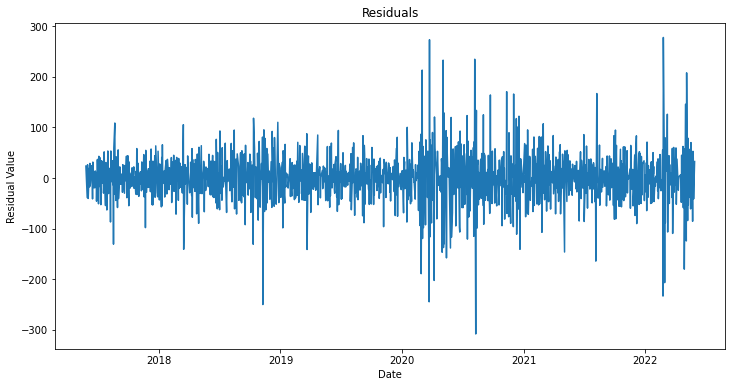

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


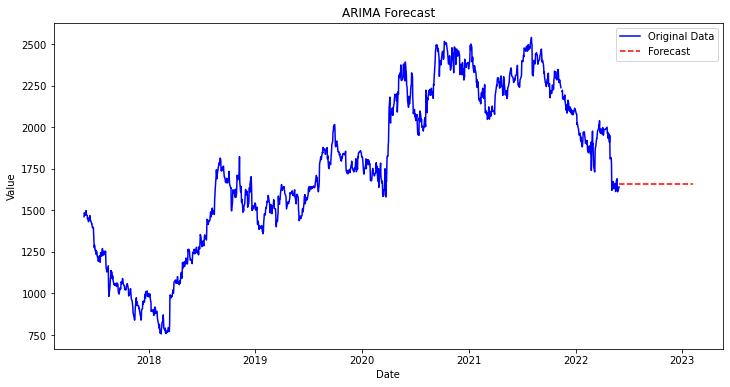

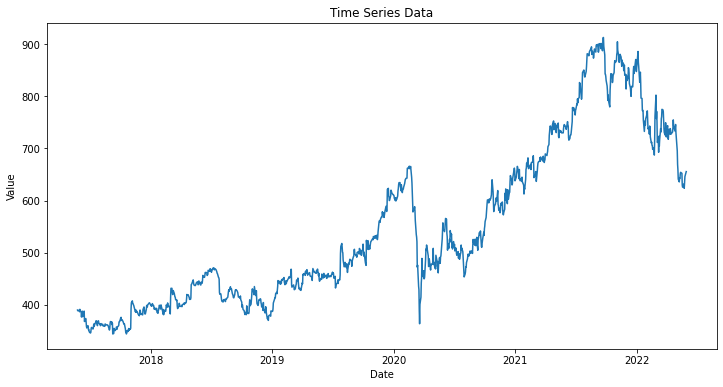

ADF Statistic: -1.2590982102240458
p-value: 0.6476711399688648
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9436.455, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9435.595, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9435.807, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9435.012, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9436.832, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.564 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4716.506
Date:                Thu, 12 Oct 2023   AIC                           9435.012
Time:                        11:30:34   BIC               

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


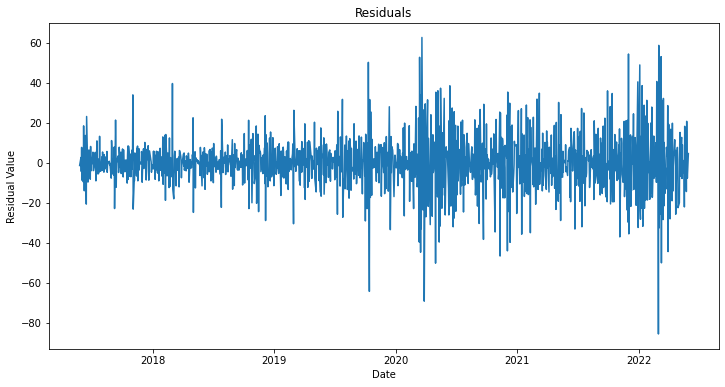

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


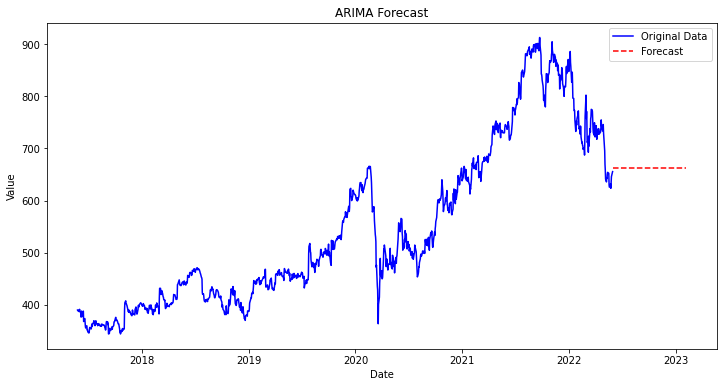

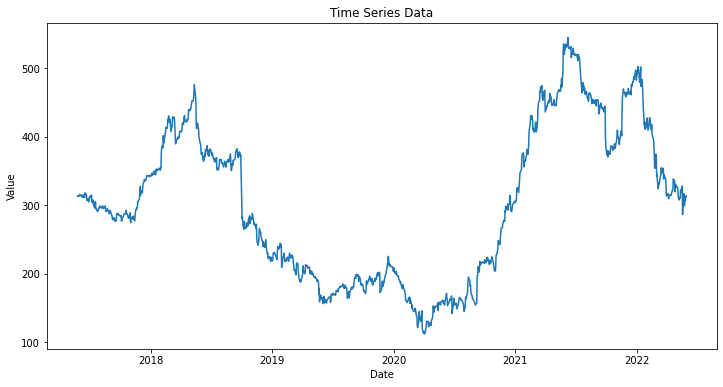

ADF Statistic: -1.0922557600377671
p-value: 0.718150316873733
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8451.496, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8452.536, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8452.600, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8449.496, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8449.769, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.623 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4223.748
Date:                Thu, 12 Oct 2023   AIC                           8449.496
Time:                        11:30:35   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


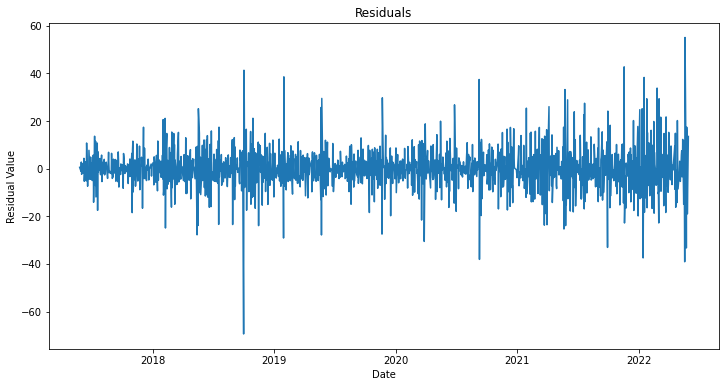

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


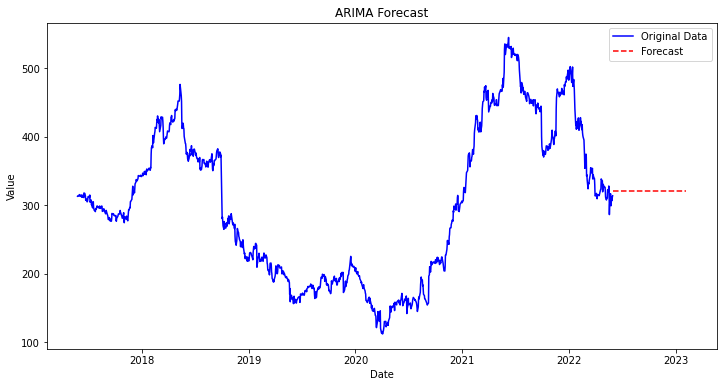

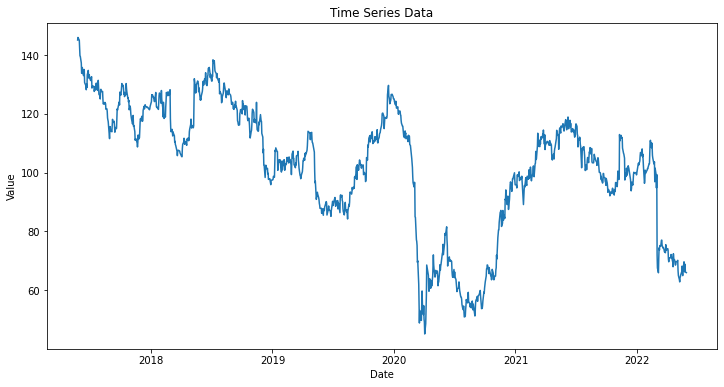

ADF Statistic: -2.016613846251952
p-value: 0.27933635078506713
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5659.548, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5661.542, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5661.542, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5658.520, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5662.081, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.781 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2828.260
Date:                Thu, 12 Oct 2023   AIC                           5658.520
Time:                        11:30:37   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


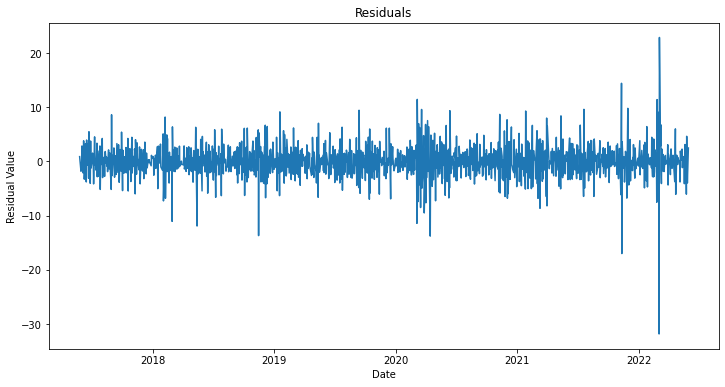

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


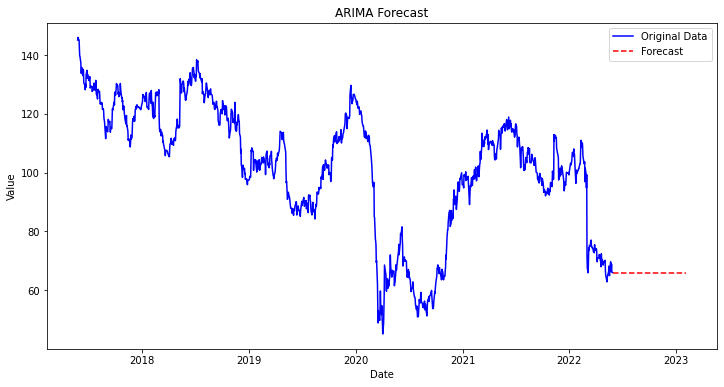

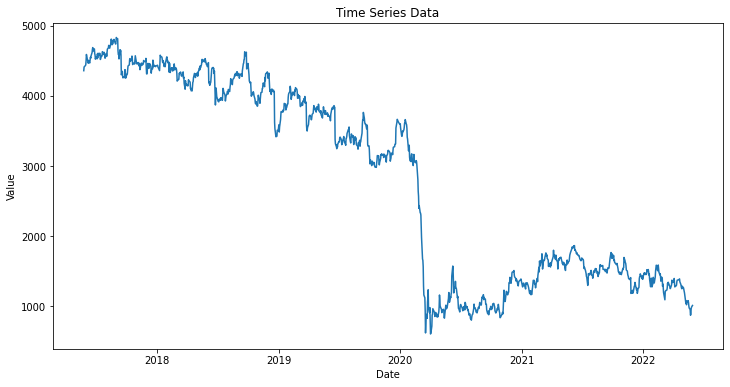

ADF Statistic: -1.086992933875947
p-value: 0.7202310016500438
Critical Values:
1%: -3.4355796466416777
5%: -2.863849421064024
10%: -2.5679995625056926
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14115.853, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14113.941, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14114.201, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14116.048, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14114.371, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14114.131, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14116.061, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14113.897, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14114.186, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14113.832, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14114.184, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AI

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


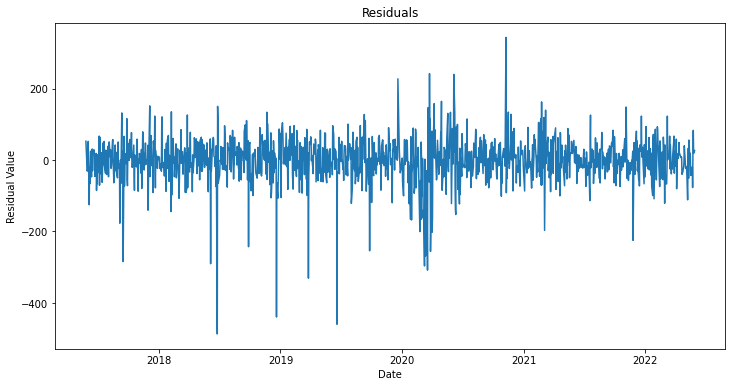

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


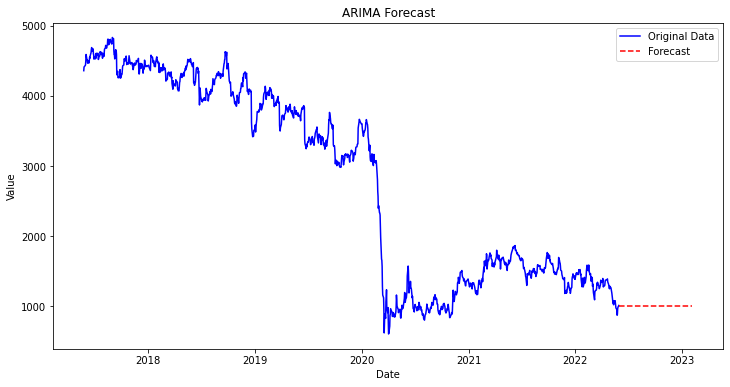

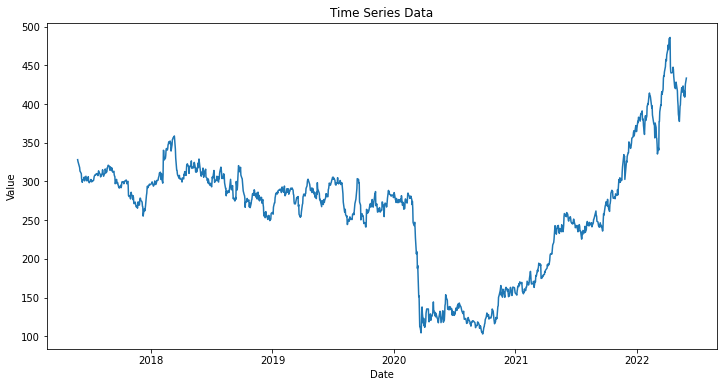

ADF Statistic: -0.7642203830811722
p-value: 0.829406846976291
Critical Values:
1%: -3.4355340425478706
5%: -2.863829299639741
10%: -2.5679888467643406
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8027.184, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8029.095, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8029.107, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8025.450, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8024.465, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8022.175, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8022.858, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8023.470, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8024.058, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8022.401, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8022.449, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8023.766,

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


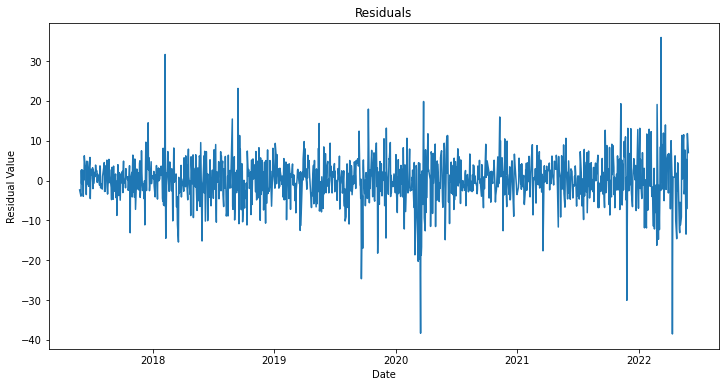

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


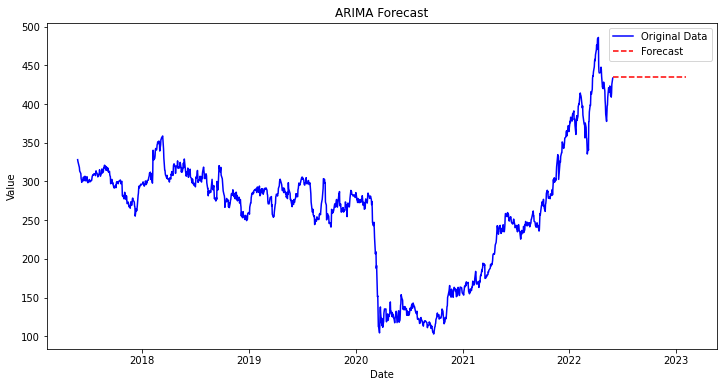

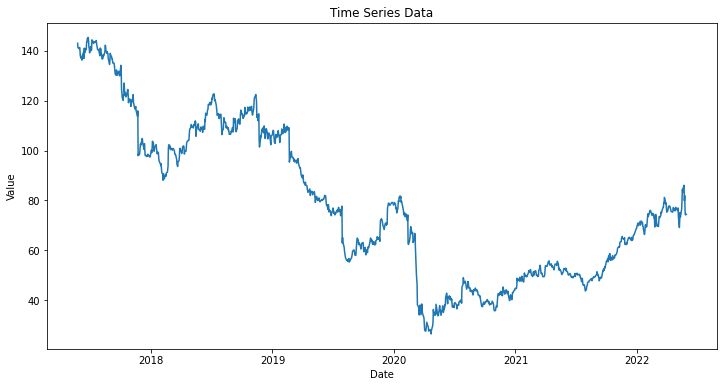

ADF Statistic: -2.1010094181194363
p-value: 0.24410890317465084
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4920.026, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4921.919, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4921.915, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4919.335, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4923.723, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.355 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2458.668
Date:                Thu, 12 Oct 2023   AIC                           4919.335
Time:                        11:30:48   BIC        

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


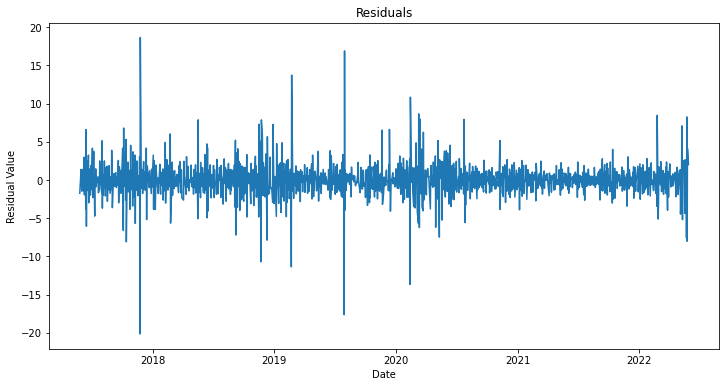

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


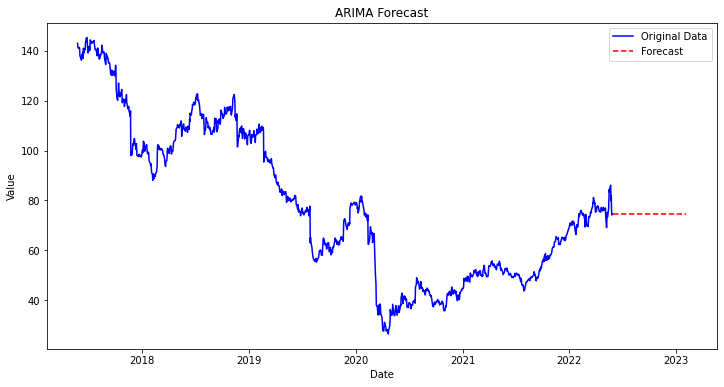

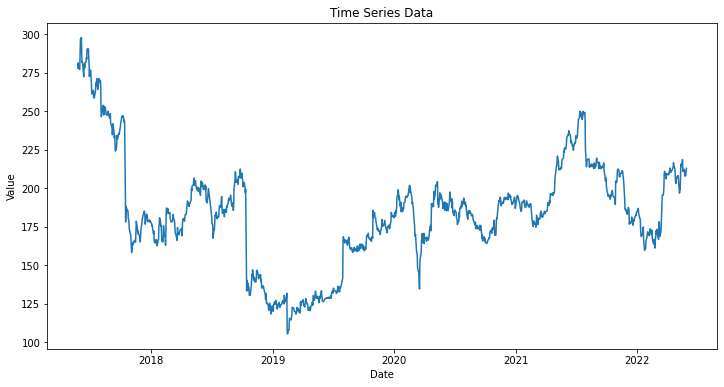

ADF Statistic: -2.8995141127910635
p-value: 0.045404528725346505
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7260.383, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7261.196, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7261.241, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7258.568, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7263.073, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.466 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3628.284
Date:                Thu, 12 Oct 2023   AIC                           7258.568
Time:                        11:30:49   BIC       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


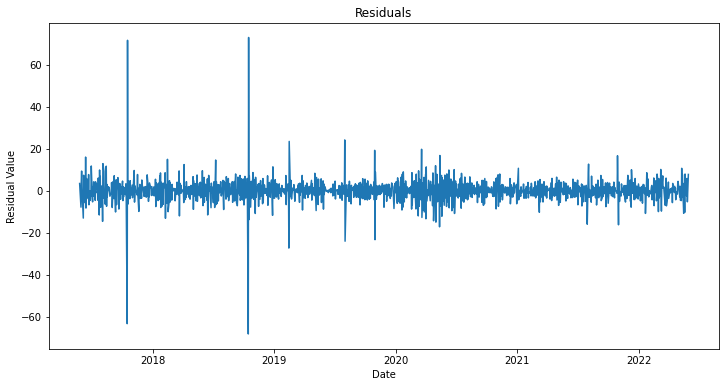

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


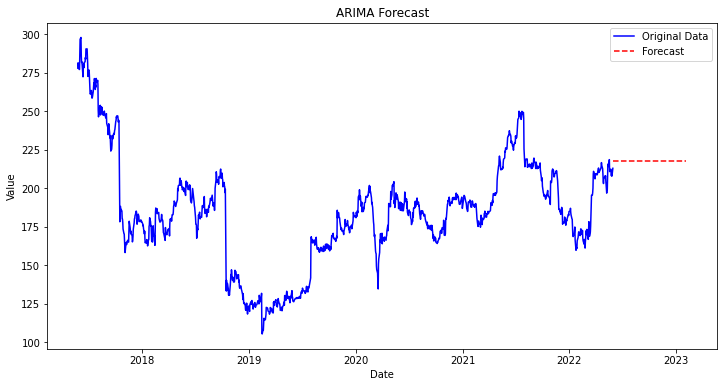

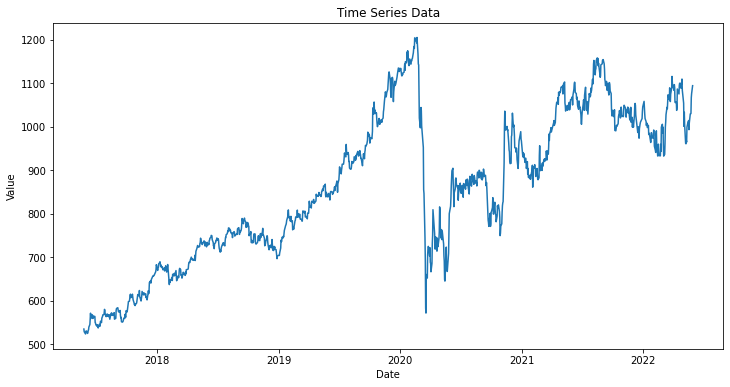

ADF Statistic: -1.986018786308587
p-value: 0.2927368195844753
Critical Values:
1%: -3.435571295403709
5%: -2.863845736356174
10%: -2.567997600196822
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10533.318, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10518.336, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10519.549, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10532.357, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10519.308, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10519.733, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10520.665, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10517.163, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10518.090, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10518.529, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10518.411, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


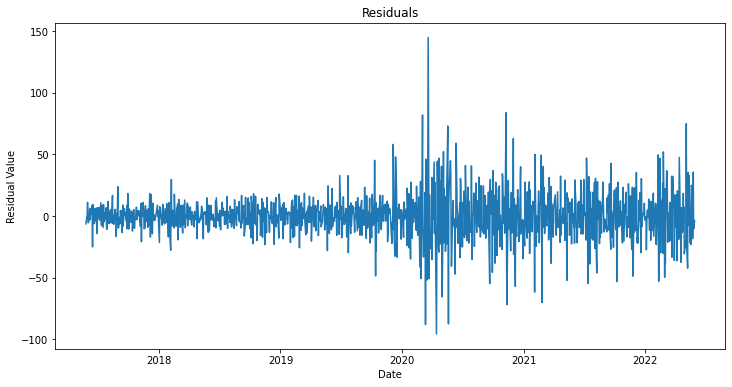

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


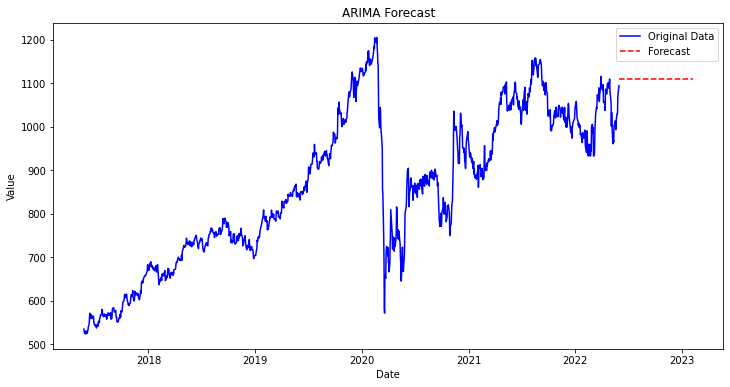

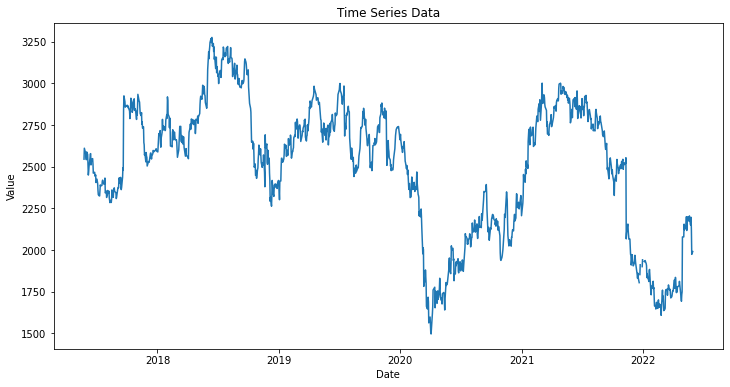

ADF Statistic: -2.0090981705418107
p-value: 0.28259817208847837
Critical Values:
1%: -3.4355381554821585
5%: -2.8638311143598556
10%: -2.567989813198476
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13423.847, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13425.635, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13425.624, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13421.948, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13426.818, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.713 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6709.974
Date:                Thu, 12 Oct 2023   AIC                          13421.948
Time:                        11:30:53   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


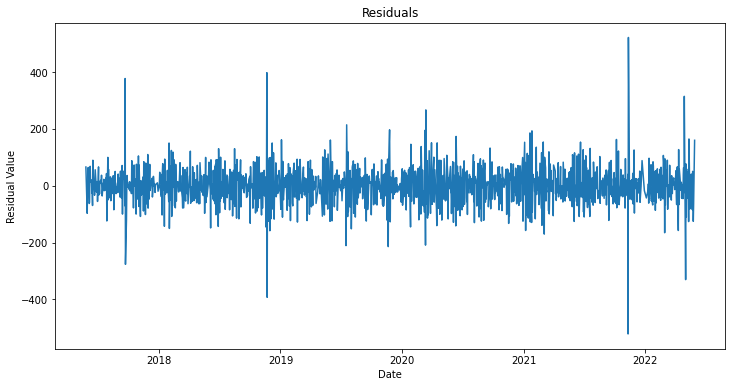

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


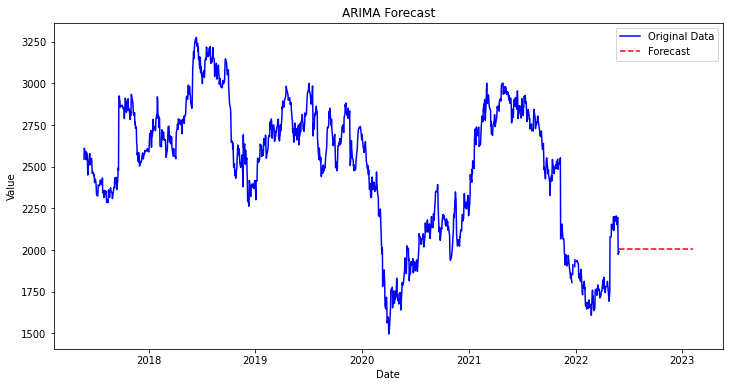

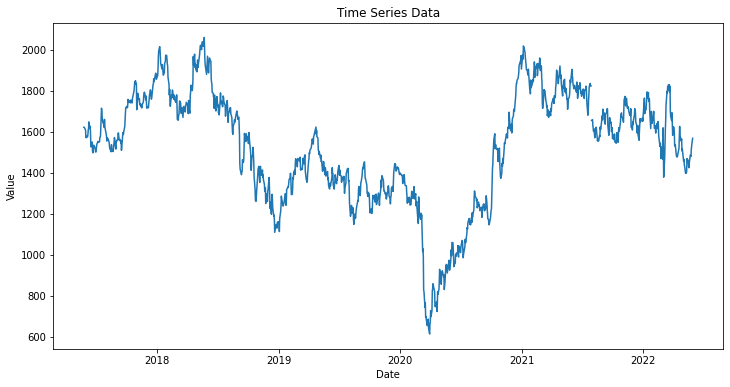

ADF Statistic: -2.1949959712573324
p-value: 0.20806664117666857
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12532.137, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12534.136, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12534.136, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12530.139, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12536.038, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.847 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6264.070
Date:                Thu, 12 Oct 2023   AIC                          12530.139
Time:                        11:30:55   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


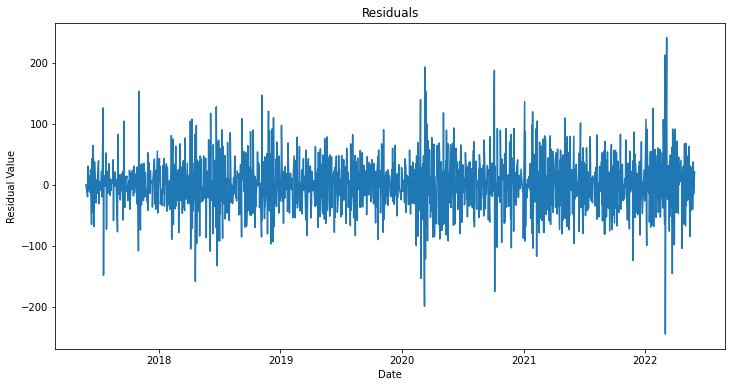

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


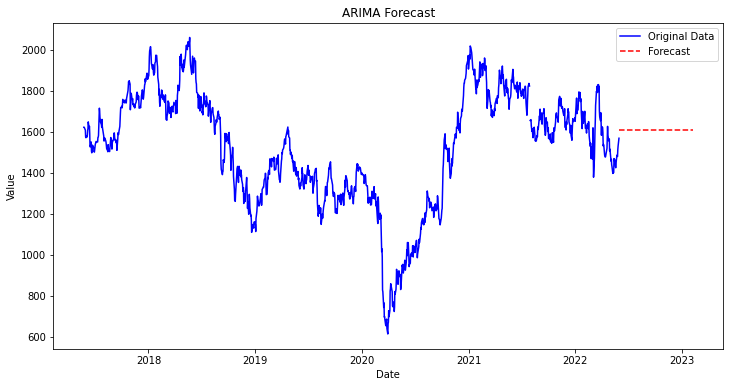

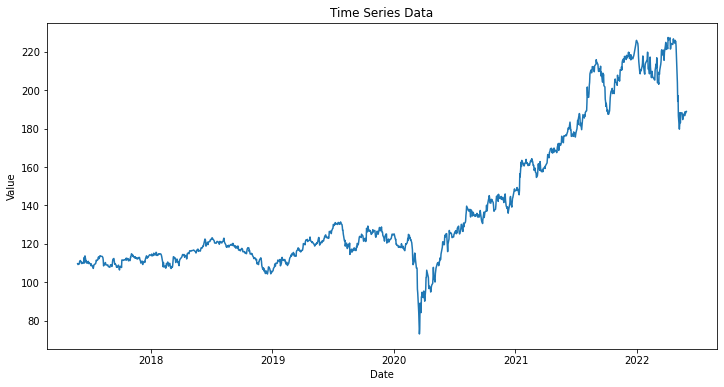

ADF Statistic: -0.5300023774732465
p-value: 0.8860275705808445
Critical Values:
1%: -3.4356175602072545
5%: -2.8638661490437025
10%: -2.5680084710921105
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5304.177, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5301.186, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5301.550, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5303.469, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5301.442, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5302.045, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5303.244, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5300.326, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5300.499, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5301.109, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5300.708, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5302.32

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


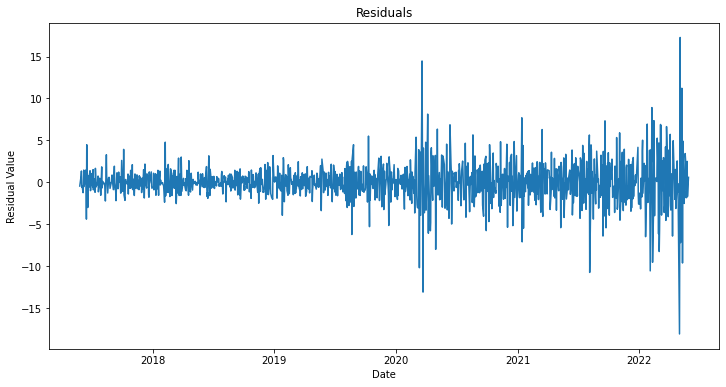

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


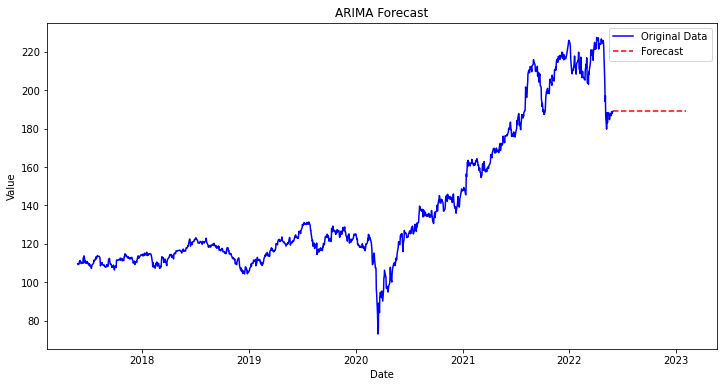

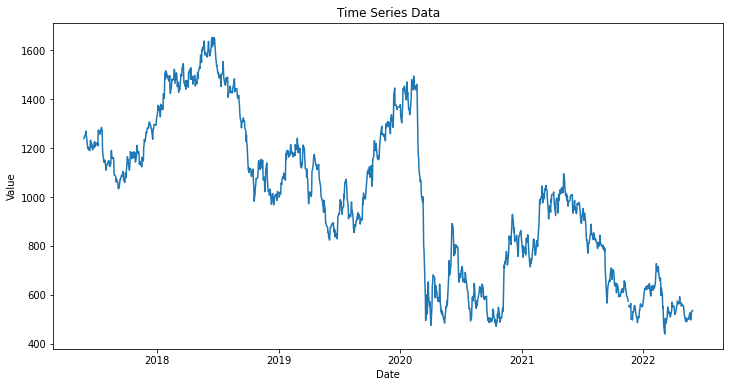

ADF Statistic: -1.5153413893180883
p-value: 0.5259089837602124
Critical Values:
1%: -3.4355340425478706
5%: -2.863829299639741
10%: -2.5679888467643406
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12016.574, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12015.538, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12015.822, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12015.080, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12015.814, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.662 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1267
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6006.540
Date:                Thu, 12 Oct 2023   AIC                          12015.080
Time:                        11:30:59   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


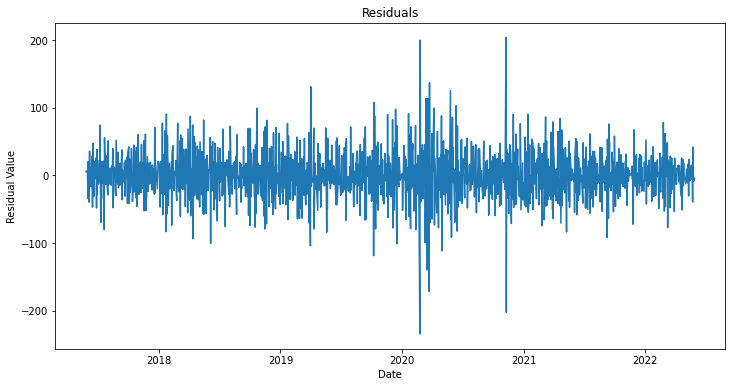

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


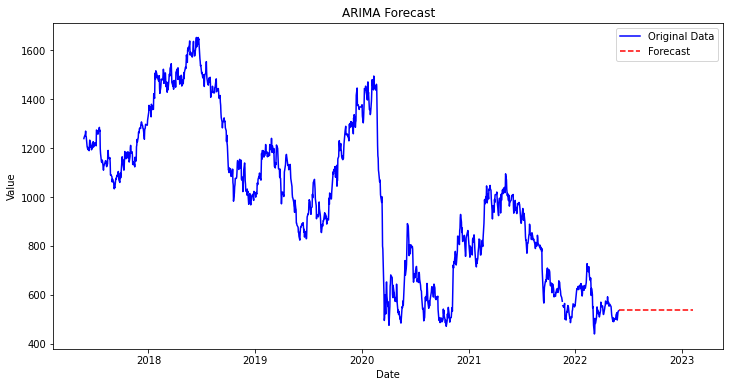

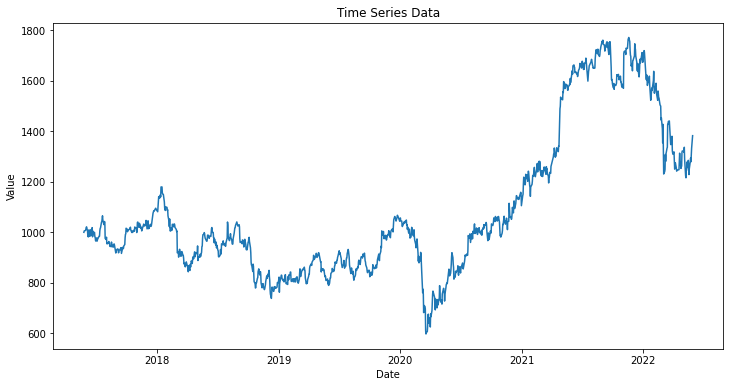

ADF Statistic: -1.0488526969336045
p-value: 0.7350322710816339
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11196.827, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11198.783, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11198.782, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11195.115, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11200.372, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.015 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5596.557
Date:                Thu, 12 Oct 2023   AIC                          11195.115
Time:                        11:31:01   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


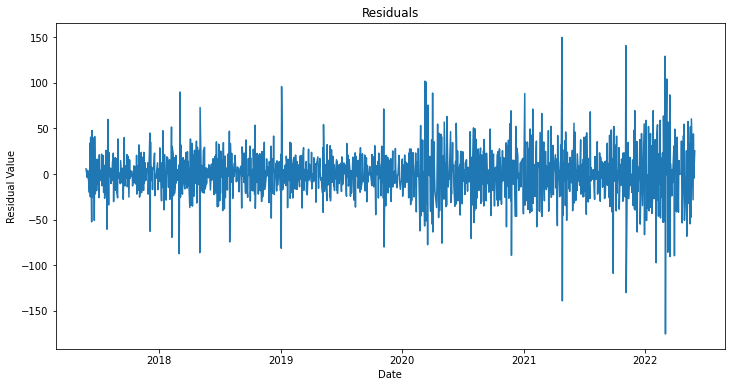

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


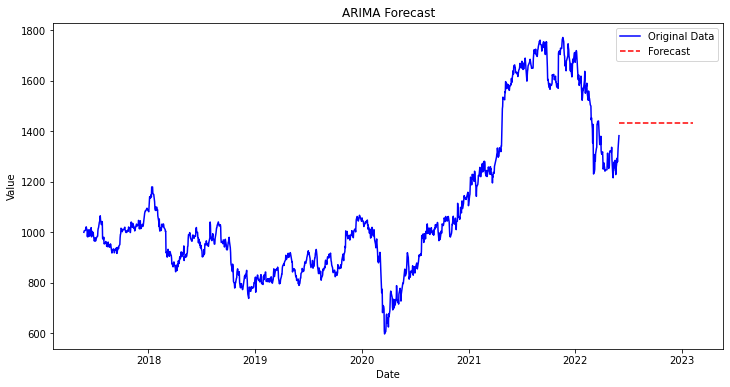

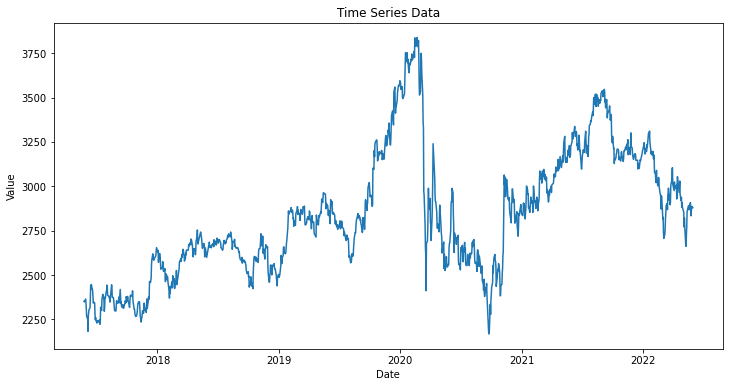

ADF Statistic: -2.2355791993660774
p-value: 0.19358653186258307
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13283.261, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13285.262, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13285.264, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13281.367, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13286.217, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.669 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6639.683
Date:                Thu, 12 Oct 2023   AIC                          13281.367
Time:                        11:31:02   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


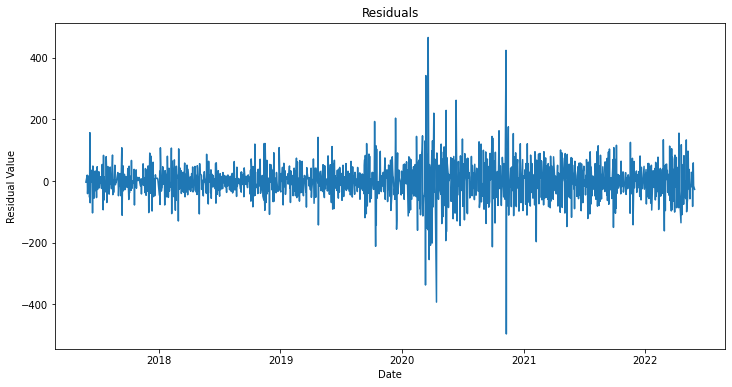

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


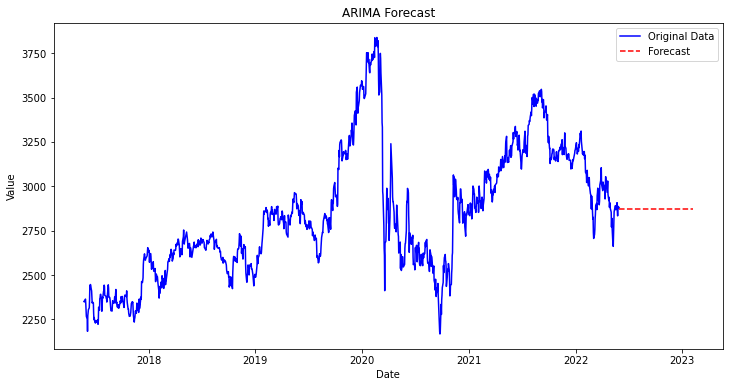

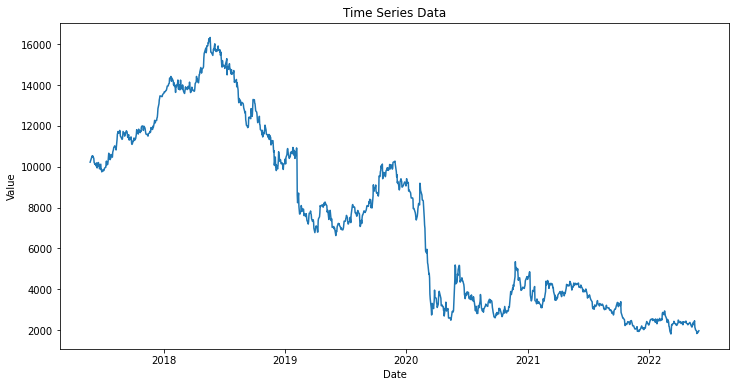

ADF Statistic: -0.4829436943902369
p-value: 0.8953021631845659
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16918.123, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16916.134, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16916.069, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16917.585, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16917.979, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16918.006, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16920.009, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16915.386, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16917.289, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16917.340, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16915.444, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


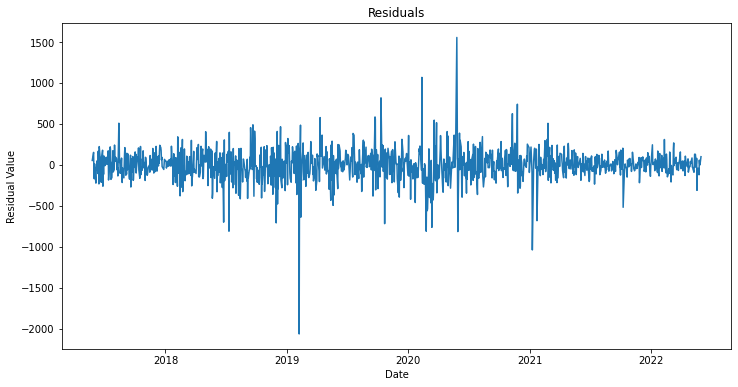

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


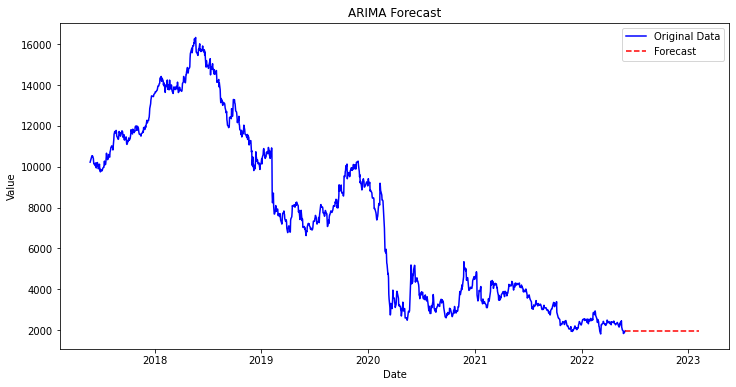

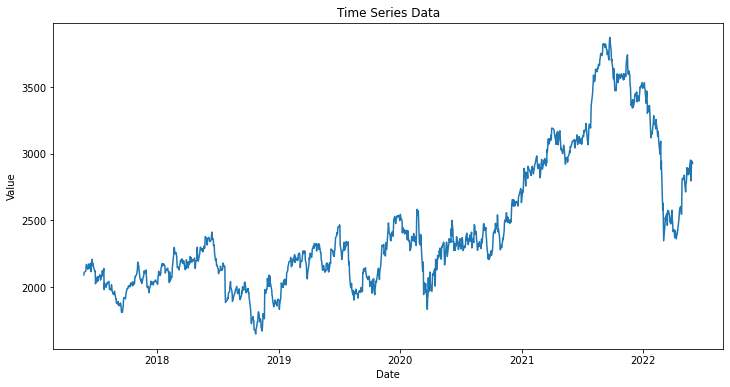

ADF Statistic: -1.3230012157226438
p-value: 0.6185846435593523
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13161.575, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13155.171, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13155.590, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13159.866, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13156.534, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13156.672, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13158.472, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13153.515, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13154.863, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13154.994, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13153.934, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


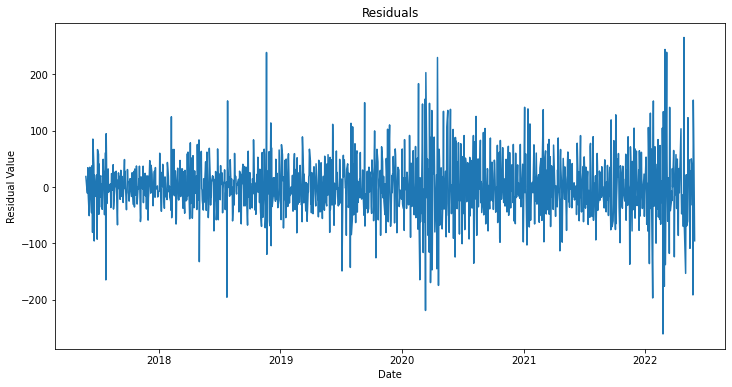

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


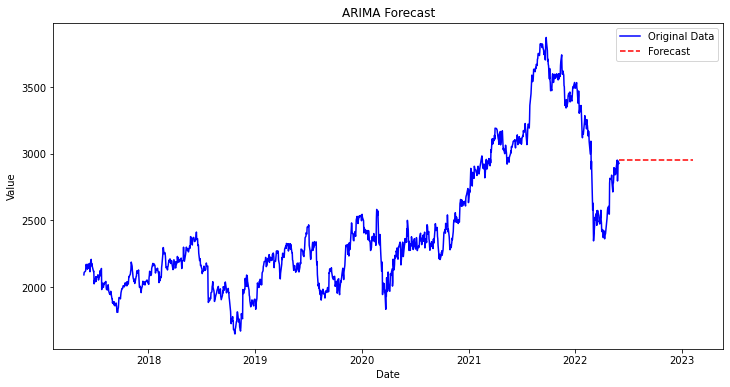

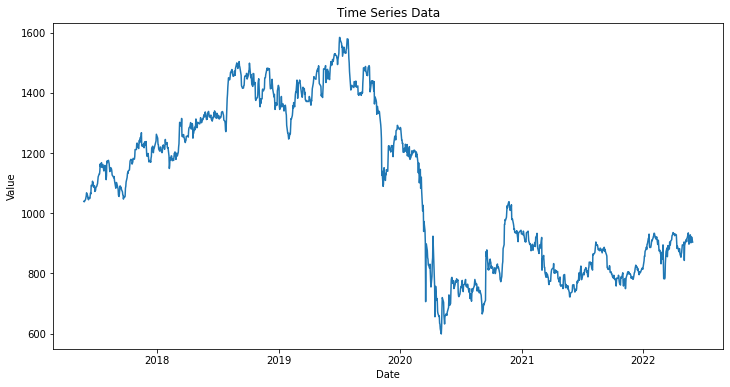

ADF Statistic: -1.311686878151742
p-value: 0.6238087362652656
Critical Values:
1%: -3.4356006420838963
5%: -2.8638586845641063
10%: -2.5680044958343604
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11231.858, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11232.578, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11232.399, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11229.893, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11231.729, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.645 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5613.947
Date:                Thu, 12 Oct 2023   AIC                          11229.893
Time:                        11:31:08   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


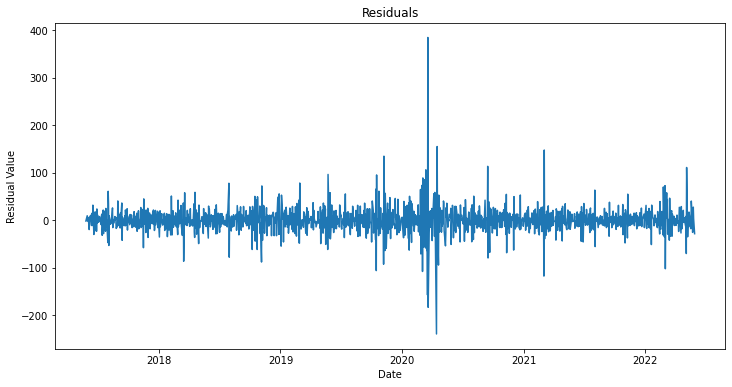

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


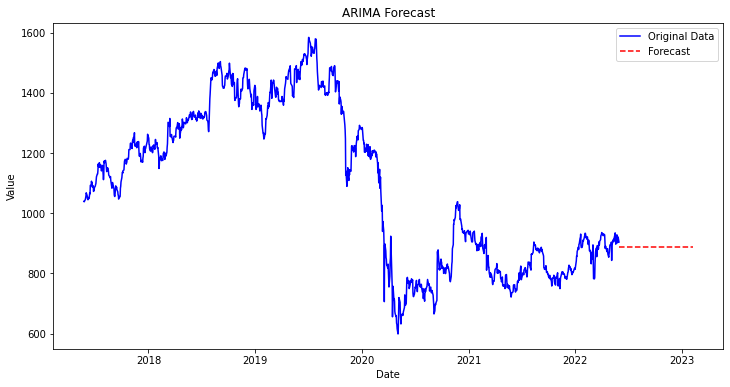

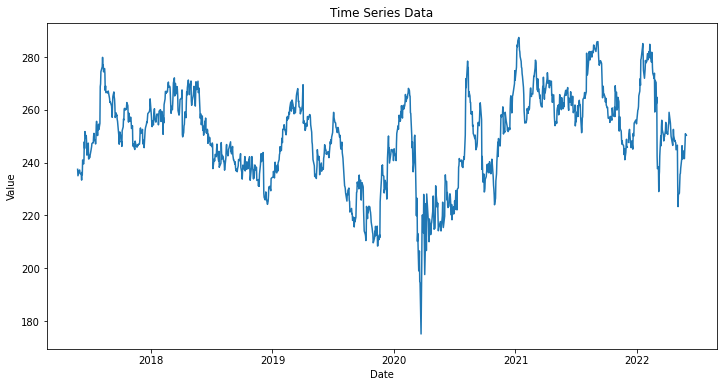

ADF Statistic: -3.737208144033995
p-value: 0.0036192076826282614
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6970.038, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6965.836, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6966.212, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6968.047, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6966.752, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6967.276, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6968.689, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6963.847, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6964.762, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6965.287, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6964.222, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6966.

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


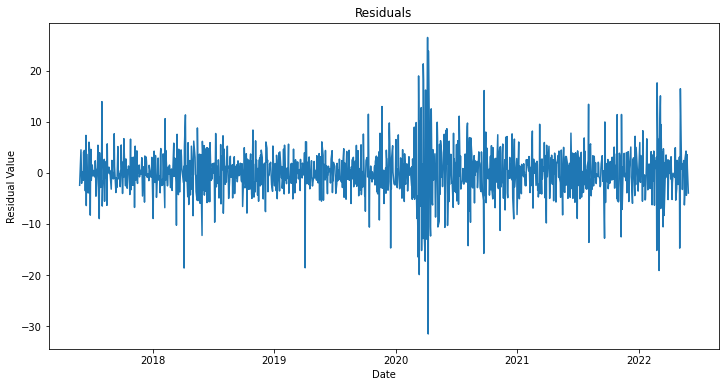

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


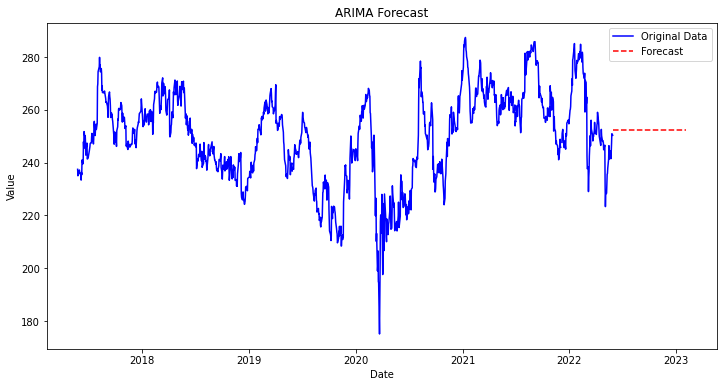

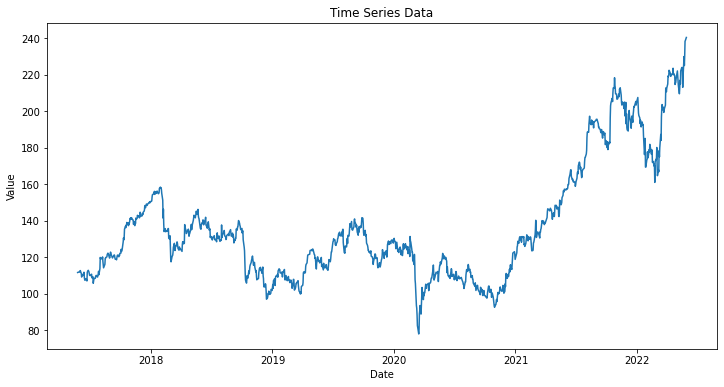

ADF Statistic: 0.02166084826016115
p-value: 0.9602871829455716
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5992.318, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5991.453, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5991.694, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5992.294, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5991.213, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5987.165, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5988.347, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5987.553, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5988.951, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5989.462, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=5986.917, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5991.206, 

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


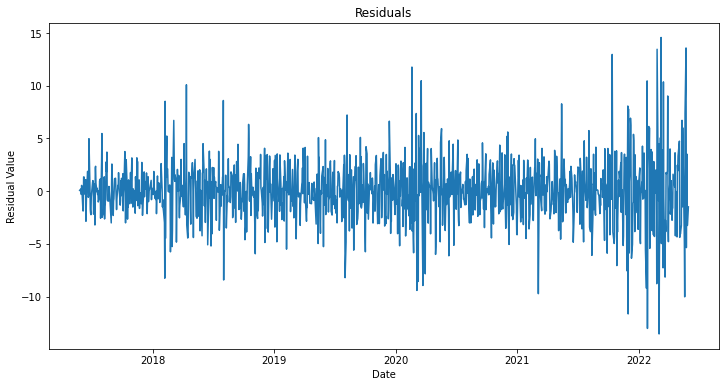

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


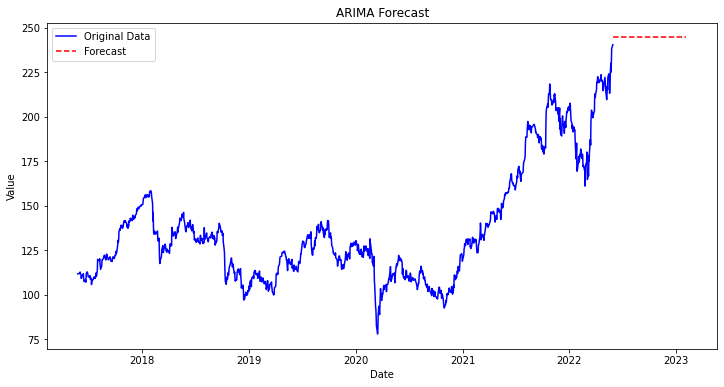

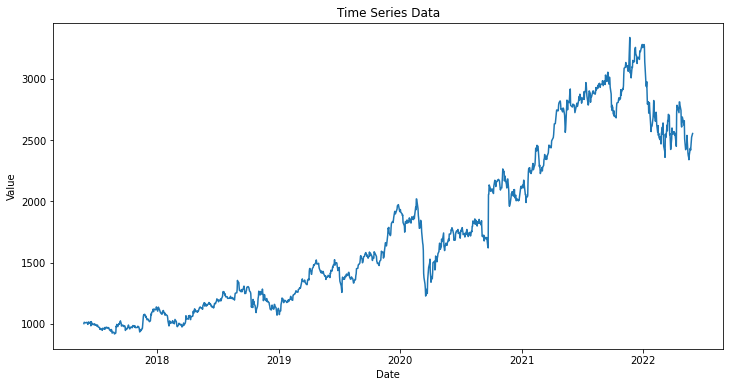

ADF Statistic: -0.9597265011456352
p-value: 0.7676683877513278
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12793.859, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12795.835, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12795.835, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12793.199, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12797.827, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.444 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6395.599
Date:                Thu, 12 Oct 2023   AIC                          12793.199
Time:                        11:31:15   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


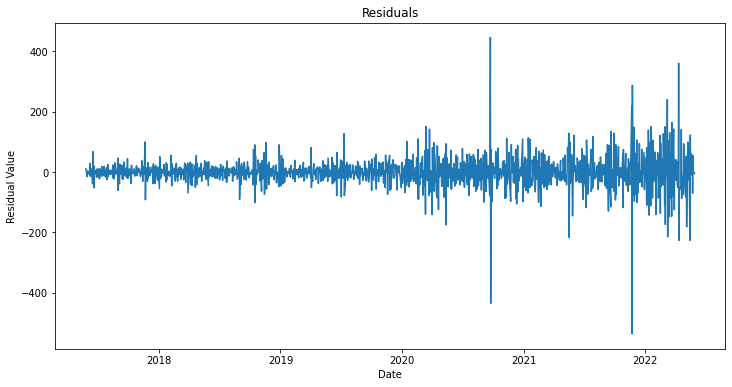

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


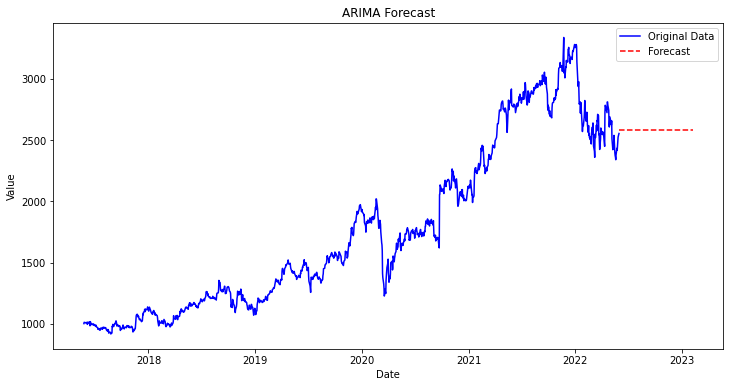

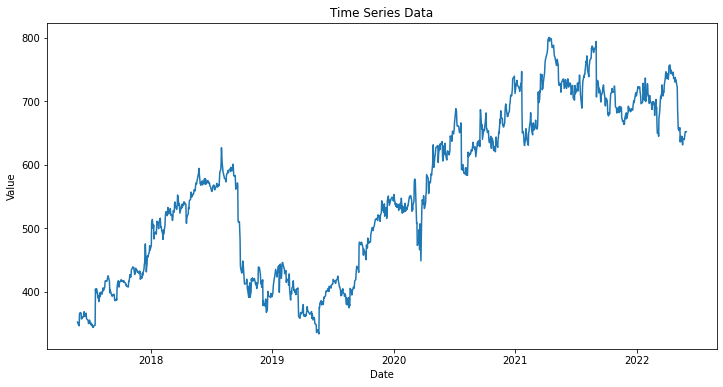

ADF Statistic: -1.7326303604861695
p-value: 0.41438356701824136
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9531.562, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9528.606, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9528.344, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9530.219, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9528.957, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9529.544, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9530.956, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9527.101, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9527.799, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9528.342, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9527.351, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9529.79

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


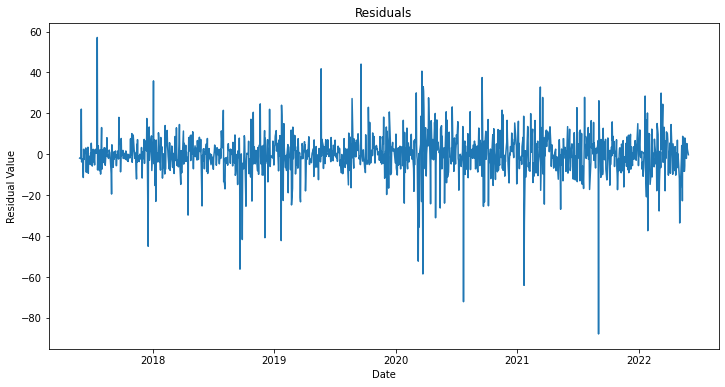

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


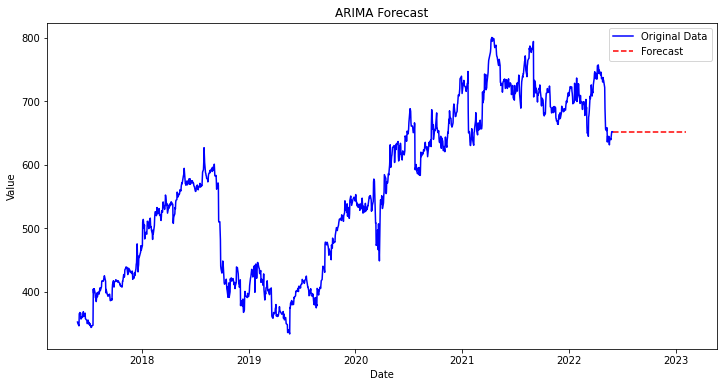

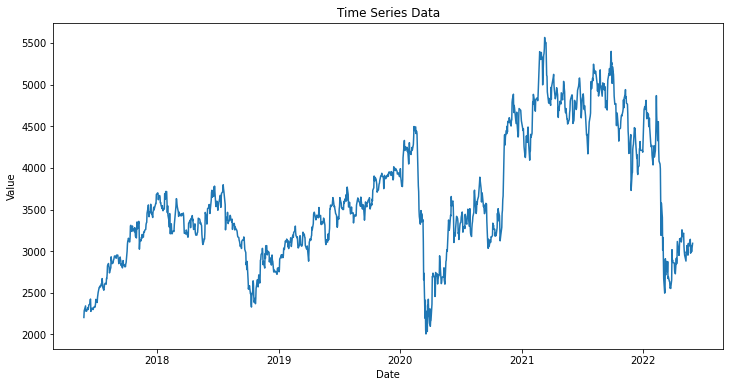

ADF Statistic: -2.6230663241360435
p-value: 0.08832301889765065
Critical Values:
1%: -3.4355464009607255
5%: -2.8638347524449888
10%: -2.5679917506718044
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15297.457, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15298.807, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15298.845, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15295.518, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15300.459, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.389 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7646.759
Date:                Thu, 12 Oct 2023   AIC                          15295.518
Time:                        11:31:19   BIC   

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


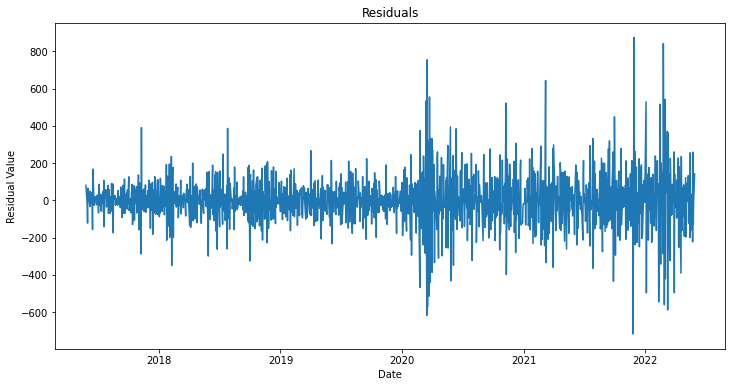

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


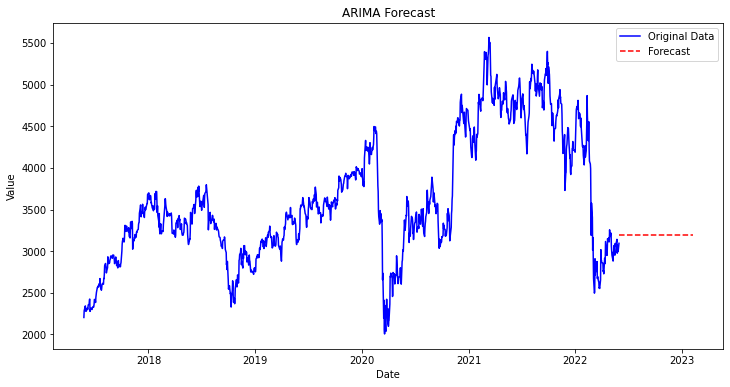

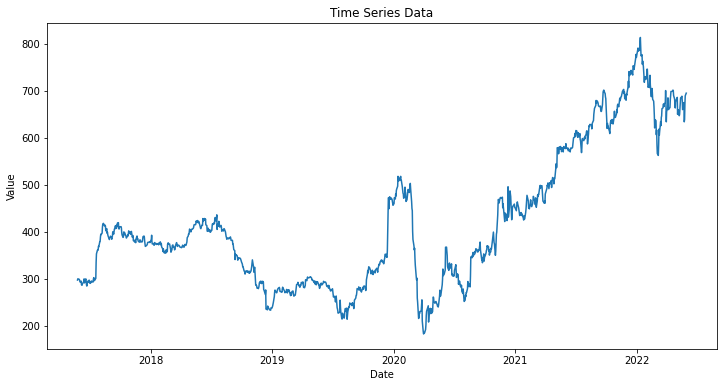

ADF Statistic: -0.6409780897599282
p-value: 0.8614512726214871
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9465.197, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9466.870, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9466.867, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9464.414, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9468.850, Time=0.66 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.894 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4731.207
Date:                Thu, 12 Oct 2023   AIC                           9464.414
Time:                        11:31:21   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


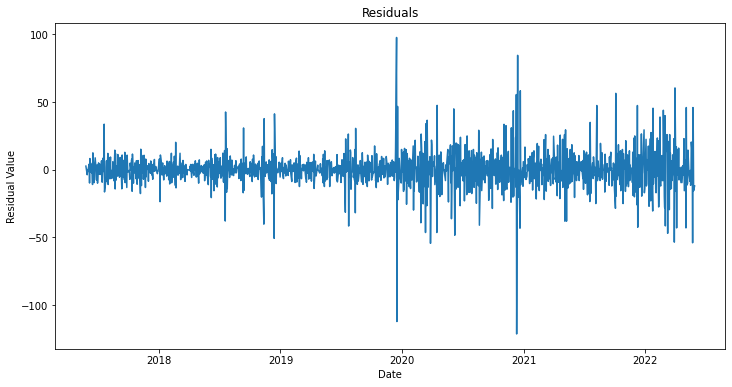

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


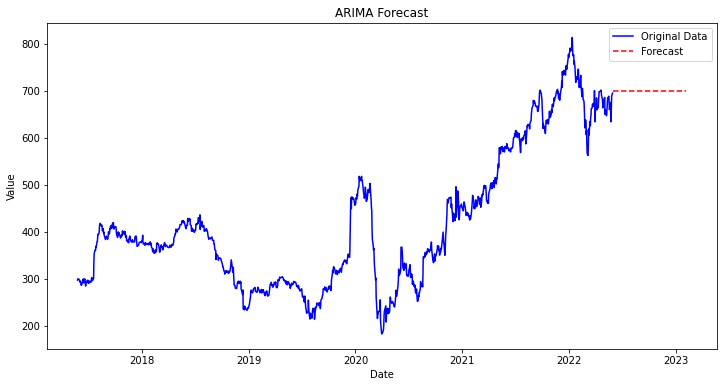

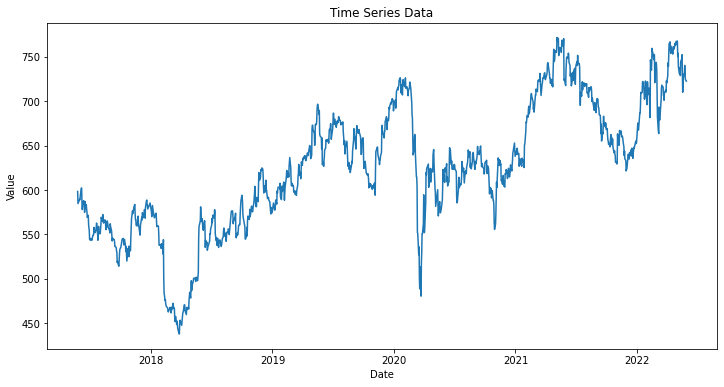

ADF Statistic: -1.8818561144493893
p-value: 0.34064411191763494
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9146.197, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9148.166, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9148.167, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9144.350, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9150.197, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.402 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4571.175
Date:                Thu, 12 Oct 2023   AIC                           9144.350
Time:                        11:31:22   BIC        

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


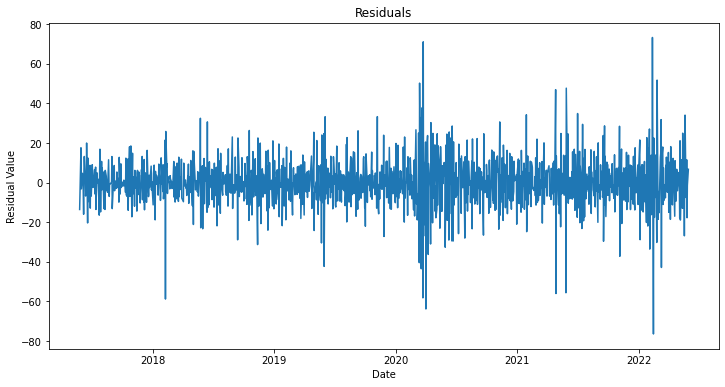

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


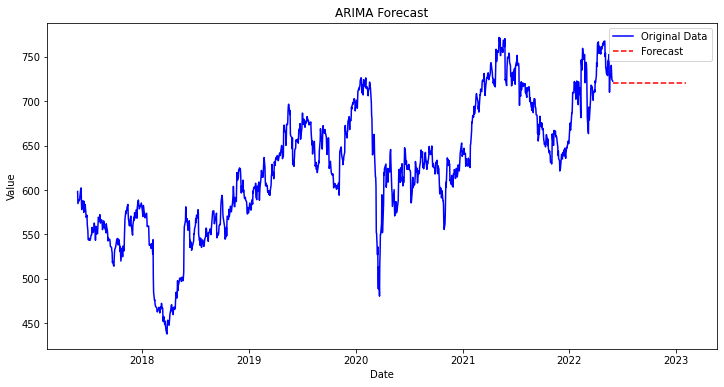

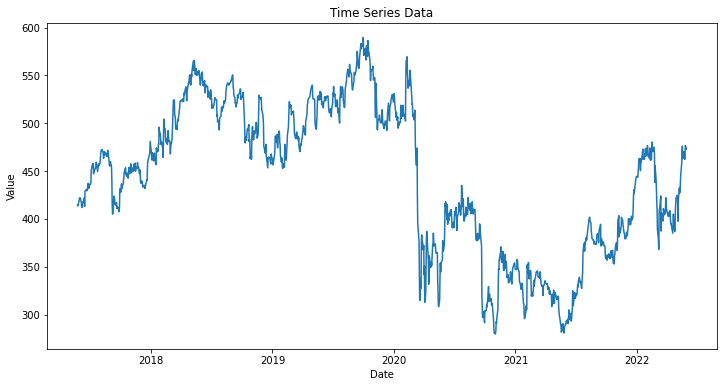

ADF Statistic: -2.033301192845991
p-value: 0.27216520645843123
Critical Values:
1%: -3.4355258362116787
5%: -2.8638256788102323
10%: -2.567986918482913
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9038.587, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9038.799, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9038.777, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9036.625, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9040.769, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.764 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4517.312
Date:                Thu, 12 Oct 2023   AIC                           9036.625
Time:                        11:31:23   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


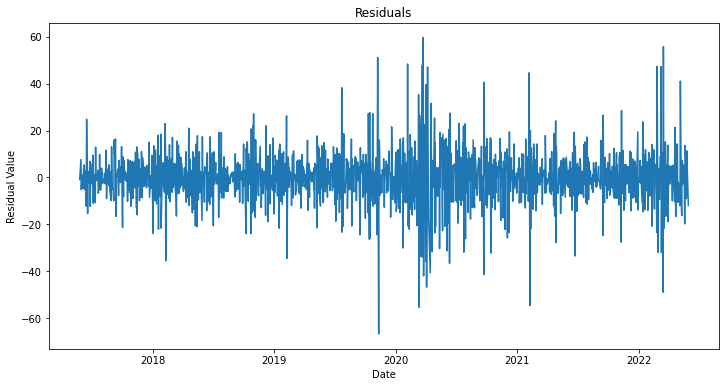

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


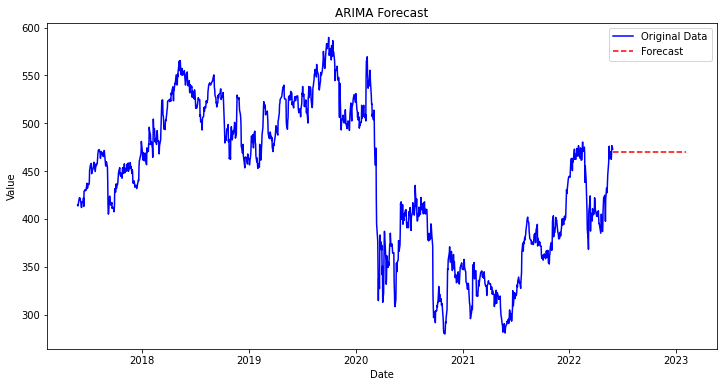

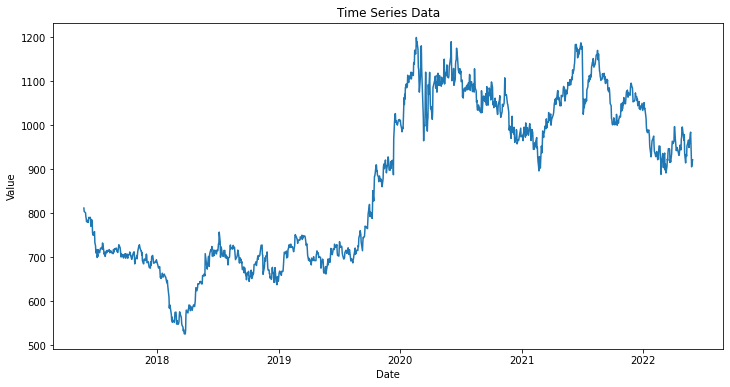

ADF Statistic: -1.2550798836141874
p-value: 0.6494647638239187
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10436.195, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10437.588, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10437.517, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10434.238, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10424.704, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10421.963, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10436.251, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10420.841, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10433.729, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10418.601, Time=0.71 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10424.963, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  war

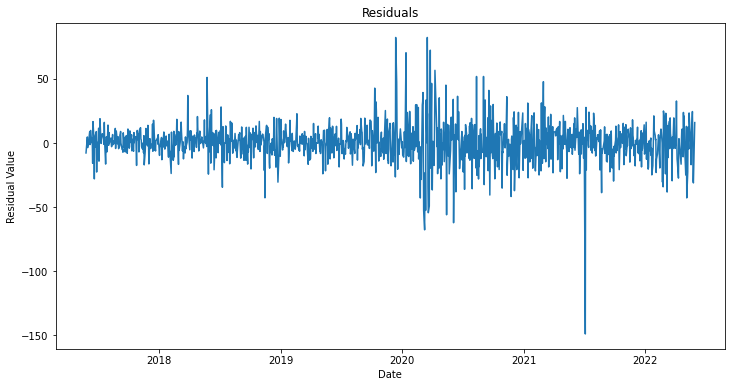

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


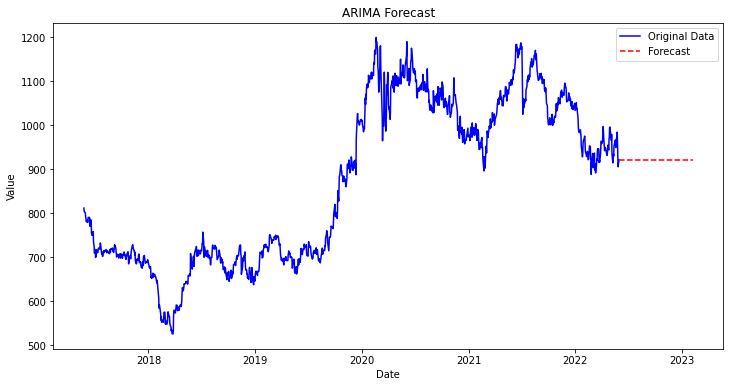

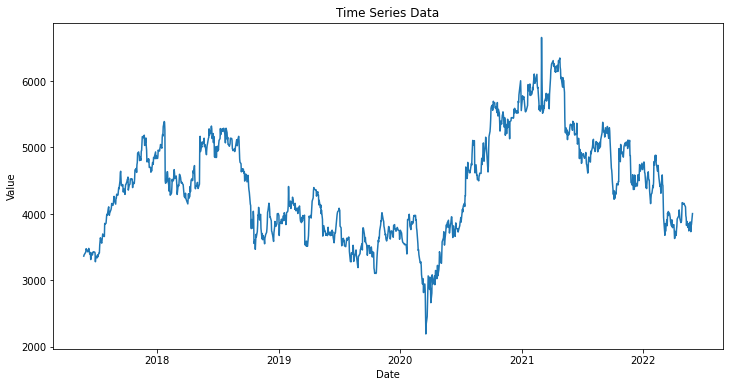

ADF Statistic: -2.590698482787082
p-value: 0.09493498130107092
Critical Values:
1%: -3.4355217427788793
5%: -2.8638238726872296
10%: -2.5679859566283705
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15390.932, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15392.844, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15392.843, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15388.961, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15391.168, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.619 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1268
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7693.481
Date:                Thu, 12 Oct 2023   AIC                          15388.961
Time:                        11:31:43   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


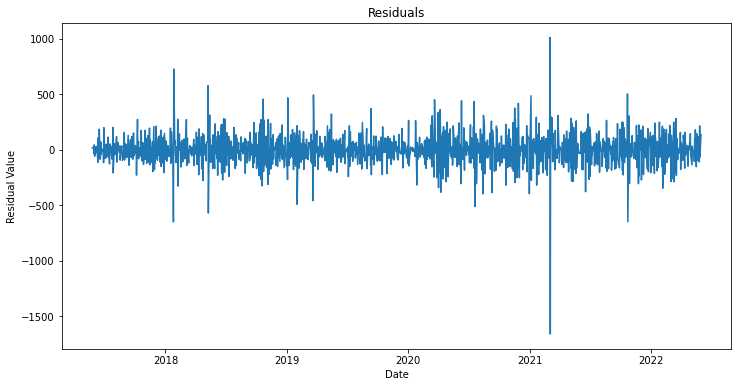

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


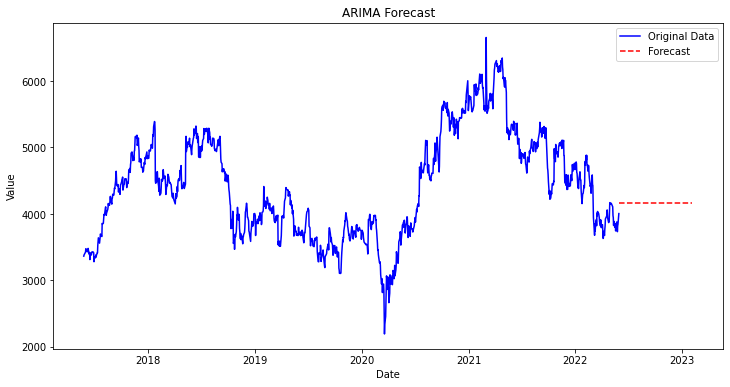

optimal_p  optimal_q  optimal_d  deviations from last known price  \
ICP.L         0.0        0.0        1.0                         14.533447   
ABDN.L        0.0        0.0        1.0                          2.032883   
SMDS.L        0.0        0.0        1.0                          2.898315   
HL.L          0.0        0.0        1.0                         10.881348   
DPH.L         1.0        0.0        1.0                         36.993786   
HIK.L         0.0        0.0        1.0                         17.780762   
HWDN.L        0.0        0.0        1.0                          7.101562   
IDS.L         0.0        0.0        1.0                          7.534912   
ITV.L         0.0        0.0        1.0                         -0.187279   
CCL.L         1.0        1.0        1.0                         -1.078806   
INVP.L        2.0        1.0        1.0                          1.477356   
CNA.L         0.0        0.0        1.0                          0.192108   
CTEC.L        0.0        0.0        1.0                          5.052399   
UTG.L         1.0        0.0        1.0                         14.207518   
JMAT.L        0.0        0.0        1.0                         16.816895   
WEIR.L        0.0        0.0        1.0                         38.384277   
BBOX.L        1.0        0.0        1.0                          0.116568   
EZJ.L         0.0        0.0        1.0                          3.200012   
IMI.L         0.0        0.0        1.0                         49.781128   
DLN.L         0.0        0.0        1.0                         -7.641602   
TUI.L         0.0        1.0        1.0                         -6.869974   
SXS.L         1.0        0.0        1.0                         23.798242   
HSX.L         0.0        0.0        1.0                        -16.955200   
DLG.L         1.0        0.0        1.0                          1.802558   
EMG.L         3.0        0.0        1.0                          4.043946   
DPLM.L        0.0        0.0        1.0                         29.422852   
IGG.L         0.0        1.0        1.0                          0.228738   
WIZZ.L        0.0        0.0        1.0                        101.000000   
FRAS.L        0.0        0.0        1.0                          5.500000   
TATE.L        0.0        0.0        1.0                         -1.919067   
BEZ.L         0.0        0.0        1.0                         -3.521820   
PNN.L         2.0        4.0        1.0                         -0.081568   
RSW.L         0.0        0.0        1.0                        160.766602   

        prediction_price  
ICP.L        1478.781738  
ABDN.L        177.436203  
SMDS.L        285.755127  
HL.L          835.002747  
DPH.L        3604.605114  
HIK.L        1658.409058  
HWDN.L        662.746155  
IDS.L         321.235565  
ITV.L          65.775307  
CCL.L        1010.421194  
INVP.L        434.950134  
CNA.L          74.576530  
CTEC.L        218.030472  
UTG.L        1108.481200  
JMAT.L       2007.754761  
WEIR.L       1606.304688  
BBOX.L        189.044379  
EZJ.L         538.400024  
IMI.L        1432.916138  
DLN.L        2871.462891  
TUI.L        1963.630026  
SXS.L        2951.737451  
HSX.L         887.070740  
DLG.L         252.167533  
EMG.L         244.441574  
DPLM.L       2583.330322  
IGG.L         652.427469  
WIZZ.L       3195.000000  
FRAS.L        700.500000  
TATE.L        720.596008  
BEZ.L         469.573578  
PNN.L         921.808935  
RSW.L        4166.206299

In [7]:
"""
ARIMA


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


params_dict = {}


for column in df.columns:

    # Visualize your time series data
    plt.figure(figsize=(12, 6))
    plt.plot(df[column])
    plt.title('Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    # Check for stationarity using Augmented Dickey-Fuller test
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(df[column].dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    
    
    
    # If the data is not stationary, apply differencing to make it stationary
    #while result[1] > 0.05:  # Adjust the significance level as needed
    
    data_diff = df[column].diff().dropna() #first differencing
    d = 1
    print("number of differencing was {}".format(d))
    
    while adfuller(data_diff)[1] > 0.05:
        data_diff = data_diff.diff().dropna()
        d += 1
        print("number of differencing was {}".format(d))

    else:
        #data_diff = data
        data_diff = df[column]
#         plt.figure(figsize=(12, 6))
#         plt.plot(data_diff)
#         plt.title('Differenced Time Series Data')
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.show()

    # Fit an ARIMA model

    p_range = range(0, 5)
    q_range = range(0, 5)

    
    # Find the best ARIMA model using auto_arima
    best_model = auto_arima(df[column].dropna(), start_p=0, d=1, start_q=0,
                            max_p=4, max_d=4, max_q=4,
                            seasonal=True, trace=True,
                            stepwise=True, error_action='ignore', suppress_warnings=True)

    print(best_model.summary())
    
    p_optimal = best_model.get_params()['order'][0]
    d_optimal = best_model.get_params()['order'][1]
    q_optimal = best_model.get_params()['order'][2]
                                                 
    
    for differencing_count in range(d_optimal):
        data_diff = data_diff.diff().dropna()
    
    model = sm.tsa.ARIMA(data_diff, order=(p_optimal, d_optimal, q_optimal))
    results = model.fit()

    # Print model summary
    #print(results.summary())

    # Plot the residuals to check for randomness
    # residuals should show no predictability in variance and have mean of 0
    residuals = results.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.show()

    # Forecast future values
    forecast_steps = 3  # Number of time steps to forecast ahead
    forecast, stderr, conf_int = results.forecast(steps=forecast_steps)
    
    #create dictionary to store params
    
    params_dict[column] = {"optimal_p": p_optimal,
                           "optimal_q": q_optimal, 
                           "optimal_d": d_optimal,
                          "deviations from last known price" : forecast,
                          "prediction_price" : forecast+df[column].iloc[-1]}

    
    last_date = df[column].index[-1]
    additional_x = 250
    forecast_index = pd.date_range(start=last_date, periods=forecast_steps+additional_x, freq='D')
    
    # Create a DataFrame for the forecasted values
    forecast_df = pd.DataFrame({'Forecast': df[column].iloc[-1]+forecast}, index=forecast_index)

    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the original data
    ax.plot(df[column], label='Original Data', color='blue')

    # Plot the forecasted values
    ax.plot(forecast_df, label='Forecast', linestyle='--', color='red')

    ax.set_title('ARIMA Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # Show the plot
    plt.show() 
    
params_df = pd.DataFrame(params_dict).T
    
display(params_df)
    


In [10]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file

Unnamed: 0  Actual Price Predicted Price       MSE       MAE  R2  \
0       CCL.L   1011.500000     [1102.1017]  0.004354  0.065982   1   
1       PNN.L    921.890503      [978.6994]  0.094318  0.307112   1   
2       IGG.L    652.198731      [628.6662]  0.035130  0.187431   1   
3       ITV.L     65.962585     [66.964294]  0.002242  0.047346   1   
4      INVP.L    433.472778      [401.9024]  0.167294  0.409016   1   
5       EMG.L    240.397629      [223.5084]  0.285668  0.534479   1   
6      TATE.L    722.515076      [747.0776]  0.113386  0.336728   1   
7       RSW.L   4005.439697     [3899.5273]  0.019304  0.138940   1   
8       IDS.L    313.700653     [276.65097]  0.108747  0.329769   1   
9       SXS.L   2927.939453     [2899.7961]  0.003010  0.054867   1   
10      HSX.L    904.025879     [924.79584]  0.005985  0.077362   1   
11     FRAS.L    695.000000      [648.7346]  0.101715  0.318928   1   
12      BEZ.L    473.095398      [459.9702]  0.027568  0.166035   1   
13     WIZZ.L   3094.000000     [3054.6003]  0.002874  0.053610   1   
14      DLN.L   2879.104248     [2870.5718]  0.000610  0.024702   1   
15      DLG.L    250.364975      [232.5869]  1.044022  1.021774   1   
16     ABDN.L    175.403336      [163.5097]  0.077741  0.278821   1   
17     DPLM.L   2553.907471     [2410.2227]  0.045431  0.213145   1   
18     BBOX.L    188.927795     [208.25749]  0.279559  0.528733   1   
19      IMI.L   1383.135132       [1250.15]  0.208410  0.456519   1   
20     HWDN.L    660.338989     [637.03265]  0.022085  0.148612   1   
21      HIK.L   1640.628174      [1627.581]  0.000760  0.027571   1   
22     JMAT.L   1990.937866     [1888.5277]  0.064393  0.253758   1   
23     SMDS.L    282.856812     [267.72086]  0.095043  0.308290   1   
24       HL.L    824.121399      [752.5042]  0.084401  0.290519   1   
25      EZJ.L    535.200012     [526.18634]  0.000791  0.028124   1   
26      DPH.L   3567.611328     [3383.6902]  0.043994  0.209748   1   
27     WEIR.L   1567.920288     [1492.0137]  0.072201  0.268702   1   
28      CNA.L     74.384422     [85.310745]  0.139973  0.374130   1   
29      ICP.L   1464.248291     [1264.2468]  0.236230  0.486035   1   
30     CTEC.L    212.978073     [172.95068]  1.607907  1.268033   1   
31      UTG.L   1094.273804      [984.9353]  0.442204  0.664984   1   
32      TUI.L   1970.500000      [1956.457]  0.000011  0.003248   1   

    Market Share      final_marketcap   
0      146260000   147,941,990,000.00   
1      261327008   240914886834.23047   
2      395398016    257878084065.0625   
3     4034409984   266120113306.78125   
4      645161984   279,660,157,671.13   
5     1199859968    288443491180.2617   
6      401665984   290209728829.28516   
7       72788496   291549931382.66016   
8      956193024    299958376095.6797   
9      102758000   300869202324.21875   
10     347103008    313790101878.2031   
11     454926016   316,173,581,120.00   
12     672462976   318139139236.83594   
13     103335000   319,718,490,000.00   
14     112291000   323297495117.43164   
15    1311399936   328,328,612,159.63   
16    1899229952    333131268597.6992   
17     134034000   342310433928.22266   
18    1903740032    359669407279.8203   
19     260858000   360,801,864,220.46   
20     548673024    362310190101.1875   
21     221079008   362708449166.77344   
22     183452992    365243508442.4922   
23    1377449984   389,621,110,507.25   
24     474319008    390896444410.0488   
25     758000000    405681609252.9297   
26     113888000   406,308,118,937.50   
27     259612000    407050921830.5664   
28    5493660160   408642737326.46484   
29     290612992    425529576882.9375   
30    2049789952    436560314277.9375   
31     435726016    476803564904.1328   
32     507431008   999,892,801,264.00

In [29]:
params_df["log_forecast/actual"] =\
(
    np.log(params_df["prediction_price"].values / file["Actual Price"].values)
)
params_df

optimal_p  optimal_q  optimal_d  deviations from last known price  \
ICP.L         0.0        0.0        1.0                         14.533447   
ABDN.L        0.0        0.0        1.0                          2.032883   
SMDS.L        0.0        0.0        1.0                          2.898315   
HL.L          0.0        0.0        1.0                         10.881348   
DPH.L         1.0        0.0        1.0                         36.993786   
HIK.L         0.0        0.0        1.0                         17.780762   
HWDN.L        0.0        0.0        1.0                          7.101562   
IDS.L         0.0        0.0        1.0                          7.534912   
ITV.L         0.0        0.0        1.0                         -0.187279   
CCL.L         1.0        1.0        1.0                         -1.078806   
INVP.L        2.0        1.0        1.0                          1.477356   
CNA.L         0.0        0.0        1.0                          0.192108   
CTEC.L        0.0        0.0        1.0                          5.052399   
UTG.L         1.0        0.0        1.0                         14.207518   
JMAT.L        0.0        0.0        1.0                         16.816895   
WEIR.L        0.0        0.0        1.0                         38.384277   
BBOX.L        1.0        0.0        1.0                          0.116568   
EZJ.L         0.0        0.0        1.0                          3.200012   
IMI.L         0.0        0.0        1.0                         49.781128   
DLN.L         0.0        0.0        1.0                         -7.641602   
TUI.L         0.0        1.0        1.0                         -6.869974   
SXS.L         1.0        0.0        1.0                         23.798242   
HSX.L         0.0        0.0        1.0                        -16.955200   
DLG.L         1.0        0.0        1.0                          1.802558   
EMG.L         3.0        0.0        1.0                          4.043946   
DPLM.L        0.0        0.0        1.0                         29.422852   
IGG.L         0.0        1.0        1.0                          0.228738   
WIZZ.L        0.0        0.0        1.0                        101.000000   
FRAS.L        0.0        0.0        1.0                          5.500000   
TATE.L        0.0        0.0        1.0                         -1.919067   
BEZ.L         0.0        0.0        1.0                         -3.521820   
PNN.L         2.0        4.0        1.0                         -0.081568   
RSW.L         0.0        0.0        1.0                        160.766602   

        prediction_price  log_forecast/actual  
ICP.L        1478.781738             0.379784  
ABDN.L        177.436203            -1.647815  
SMDS.L        285.755127            -0.825214  
HL.L          835.002747             2.538347  
DPH.L        3604.605114             2.118139  
HIK.L        1658.409058             1.931320  
HWDN.L        662.746155            -0.086346  
IDS.L         321.235565            -2.523234  
ITV.L          65.775307            -1.562195  
CCL.L        1010.421194            -1.063932  
INVP.L        434.950134            -0.731627  
CNA.L          74.576530            -2.232086  
CTEC.L        218.030472            -0.774662  
UTG.L        1108.481200            -1.026474  
JMAT.L       2007.754761            -0.360462  
WEIR.L       1606.304688             1.858772  
BBOX.L        189.044379             0.074894  
EZJ.L         538.400024            -1.556778  
IMI.L        1432.916138             2.026102  
DLN.L        2871.462891             0.730469  
TUI.L        1963.630026             1.089797  
SXS.L        2951.737451             0.587315  
HSX.L         887.070740            -0.808436  
DLG.L         252.167533            -0.114847  
EMG.L         244.441574            -1.215342  
DPLM.L       2583.330322             1.574194  
IGG.L         652.427469            -1.698952  
WIZZ.L       3195.000000             0.711837

<Axes: >

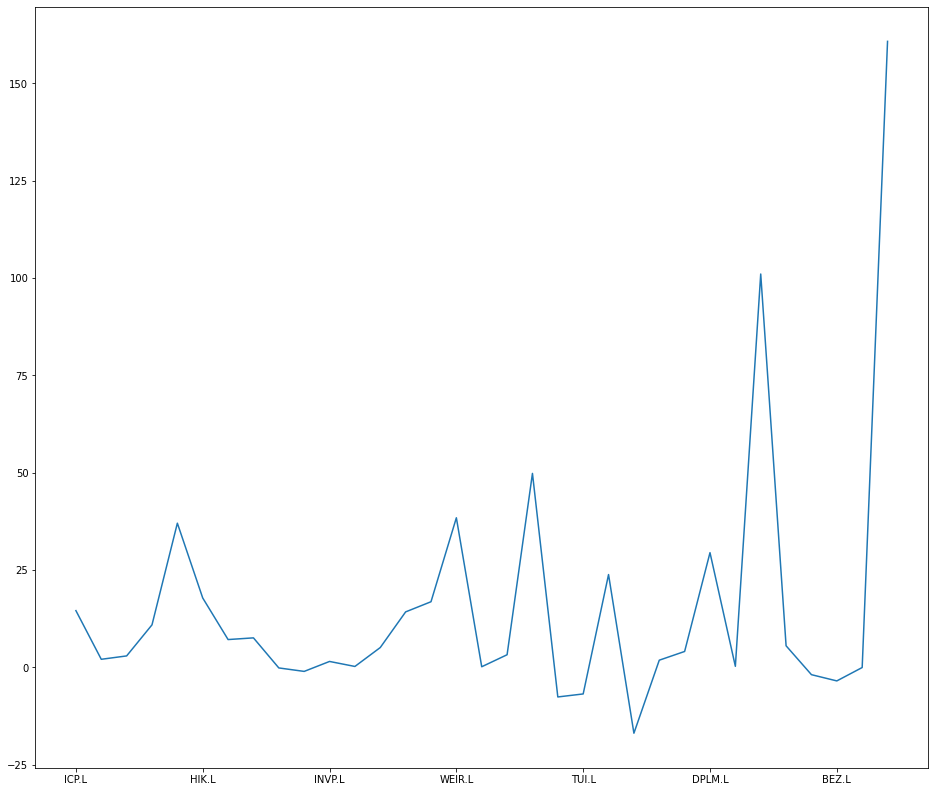

In [38]:
#however, this is not good analysis because the analysis should be factor in the stock price as a reference.
params_df["deviations from last known price"].plot(figsize=[16,14])

<Axes: >

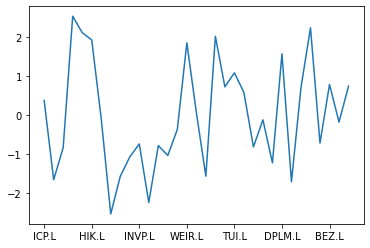

In [32]:
params_df["log_forecast/actual"].plot()

In [36]:
#can we use this mean as a measure of comparison between ARIMA and LSTM?
#larger mean away from 0 implies lower accuracy

abs(params_df["log_forecast/actual"]).mean()

1.1670242207477184

In [39]:
params_df.to_excel("params_df.xlsx")